# Multi-Task Edit Calculus V2: Edit Fragment Embeddings

This notebook compares **two approaches** for predicting property changes:

## 🎯 The Question:
**Does learning shared edit embeddings across tasks improve property change prediction?**

## 🔬 Two Approaches:

### **Edit Framework (Our Approach):**
- Learns **shared edit embeddings** across 5 biological properties
- Directly predicts: `(mol_a, mol_b) → Δproperty`
- Hypothesis: Edit patterns transfer across tasks

### **Baseline (Property Predictor):**
- Learns **molecule property values**
- Predicts: `mol → property`, then computes `Δ = property_b - property_a`
- No explicit edit concept

## 📊 Fair Comparison:
- Both use multi-task learning (5 tasks)
- Both use shared representations + task-specific heads
- Same data, architecture size, training procedure
- **Only difference**: Edit embeddings vs. molecule embeddings

## 🆕 Version 2: Edit Fragment Embeddings (Mode 2)

**Key Difference from V1:**
- **V1 (Mode 1)**: Uses full molecule embeddings: `edit_emb = MLP(Embed(mol_b) - Embed(mol_a))`
- **V2 (Mode 2)**: Uses edit fragment embeddings: `edit_emb = MLP(Embed(frag_b) - Embed(frag_a))`

**Benefits of Mode 2:**
- ✅ Scaffold-independent: Same transformation always produces same edit vector
- ✅ Better transfer learning across different molecular scaffolds
- ✅ More interpretable: Edit embeddings represent pure transformations
- ✅ More sample efficient: Shares edit statistics across all molecules

**Implementation:**
- Extracts fragments from `edit_smiles` column (format: `reactant_fragment>>product_fragment`)
- Embeds fragments separately using ChemProp
- Trains trainable edit layer on fragment differences

---


## 1. Configuration

In [25]:
DATA_FILE = '../data/pairs/chembl_pairs_long_sample.csv'
MIN_PAIRS_PER_PROPERTY = 3000
NUM_TASKS = 10

# Split Configuration
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_SEED = 42

# Data Splitter Selection
# Options: 'random', 'scaffold', 'target', 'butina', 'stratified', 'temporal'
SPLITTER_TYPE = 'scaffold'  # Change this to use different splitting strategies

# Splitter-specific parameters
SPLITTER_PARAMS = {
    'scaffold': {
        'use_generic': True  # True = more grouping (generic scaffolds)
    },
    'target': {
        'target_col': 'target_id'  # Column name for biological targets (if available)
    },
    'butina': {
        'cutoff': 0.35,      # Similarity threshold (lower = stricter)
        'fp_radius': 2,      # Morgan fingerprint radius
        'fp_size': 2048      # Fingerprint size
    },
    'stratified': {
        'property_col': 'delta',  # Column to stratify by
        'n_bins': 5               # Number of bins
    },
    'temporal': {
        'time_col': 'timestamp'   # Column with timestamps (if available)
    }
}

# Molecule Embedder Selection
# Options: 'morgan', 'rdkit', 'maccs', 'atompair', 'chemberta', 'chemprop'
EMBEDDER_TYPE = 'chemprop'

# Morgan fingerprint parameters (used if EMBEDDER_TYPE is 'morgan', 'rdkit', etc.)
FP_TYPE = 'chemprop'
FP_RADIUS = 2
FP_BITS = 2048

# Model architecture (same for both)
TRAINABLE_EDIT_DIMS = [1024, 512]  # Edit embedding layers
HIDDEN_DIMS = [512, 256, 128, 64]   # Shared backbone (increased capacity for baseline)
DROPOUT = 0.2

# Training (same for both)
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
MAX_EPOCHS = 100

# Model saving/loading
# Set to None to train from scratch, or provide path to load existing model
EDIT_MODEL_PATH = None # e.g., '../models/edit_model.pt' or None
BASELINE_MODEL_PATH = None  # e.g., '../models/baseline_model.pt' or None

# Set to True to save models after training
SAVE_MODELS = '/Users/shaharharel/Documents/github/edit-chem/models/baseline_property_predictor.pt'
MODELS_DIR = '../models'  # Directory to save models

print("✓ Configuration loaded")


✓ Configuration loaded


In [26]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Check embedder availability
try:
    from transformers import AutoTokenizer, AutoModel
    CHEMBERTA_AVAILABLE = True
except ImportError:
    CHEMBERTA_AVAILABLE = False

try:
    import chemprop
    CHEMPROP_AVAILABLE = True
except ImportError:
    CHEMPROP_AVAILABLE = False

from src.embedding.small_molecule import (
    FingerprintEmbedder,
    ChemBERTaEmbedder,
    ChemPropEmbedder
)
from src.models import EditEffectPredictor, PropertyPredictor
from src.utils.embedding_cache import (
    EmbeddingCache,
    compute_all_embeddings_once,
    map_embeddings_to_pairs,
    map_embeddings_to_molecules,
    compute_all_embeddings_with_fragments,
    map_fragment_embeddings_to_pairs
)

# Configuration
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline


## 2. Find 5 Properties with Maximum Shared Edits

In [27]:
print("Loading data...")
df_long = pd.read_csv(DATA_FILE)

print(f"Dataset: {len(df_long):,} rows, {df_long['property_name'].nunique()} properties")

# Get candidates with sufficient pairs
prop_counts = df_long.groupby('property_name').size().sort_values(ascending=False)
candidates = prop_counts[prop_counts >= MIN_PAIRS_PER_PROPERTY].index.tolist()

# Build edit sets
prop_edit_sets = {}
for prop in candidates:
    prop_edit_sets[prop] = set(df_long[df_long['property_name'] == prop]['edit_name'])

# Find best combination with maximum shared edits
print(f"Finding {NUM_TASKS} properties with maximum shared edits...")

best_combo = None
best_shared = 0

for combo in combinations(list(prop_edit_sets.keys())[:12], NUM_TASKS):
    shared = prop_edit_sets[combo[0]].copy()
    for prop in combo[1:]:
        shared &= prop_edit_sets[prop]

    if len(shared) > best_shared:
        best_shared = len(shared)
        best_combo = combo

selected_properties = list(best_combo)

print(f"\nSelected {NUM_TASKS} properties ({best_shared} shared edits):")
for i, prop in enumerate(selected_properties, 1):
    print(f"{i}. {prop}")


Loading data...
Dataset: 1,881,223 rows, 27 properties
Finding 10 properties with maximum shared edits...

Selected 10 properties (3 shared edits):
1. d(2)_dopamine_recept_ki
2. epidermal_growth_fac_ic50
3. beta_secretase_1_ic50
4. voltage_gated_inward_ic50
5. vascular_endothelial_ic50
6. voltage_gated_inward_ki
7. d(2)_dopamine_recept_ic50
8. tyrosine_protein_kin_ic50
9. beta_secretase_1_ki
10. vascular_endothelial_ki


## 3. Prepare Datasets

In [28]:
# Filter to edits appearing in multiple properties
df_filtered = df_long[df_long['property_name'].isin(selected_properties)].copy()

edit_property_counts = df_filtered.groupby('edit_name')['property_name'].nunique()
multi_property_edits = edit_property_counts[edit_property_counts > 1].index
df_filtered = df_filtered[df_filtered['edit_name'].isin(multi_property_edits)].copy()

print(f"\nFiltered: {len(df_filtered):,} pairs, {len(multi_property_edits):,} edits (appearing in >1 property)")



Filtered: 201,137 pairs, 9,016 edits (appearing in >1 property)


In [24]:
# Split per property using configured splitter
from src.utils import get_splitter

splits = {}
print(f"\nSplitting using {SPLITTER_TYPE.upper()} split (train={TRAIN_RATIO}, val={VAL_RATIO}, test={TEST_RATIO}):\n")

# Get splitter parameters
splitter_kwargs = SPLITTER_PARAMS.get(SPLITTER_TYPE, {})

for prop in selected_properties:
    data = df_filtered[df_filtered['property_name'] == prop][[
        'mol_a', 'mol_b', 'edit_name', 'edit_smiles', 'value_a', 'value_b', 'delta'
    ]].copy()
    
    # Create splitter
    if SPLITTER_TYPE == 'random':
        # Use sklearn's train_test_split for simple random split (backwards compatible)
        from sklearn.model_selection import train_test_split
        train, temp = train_test_split(data, test_size=(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
        val, test = train_test_split(temp, test_size=TEST_RATIO/(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
    
    elif SPLITTER_TYPE == 'scaffold':
        # Scaffold split (most challenging for chemistry!)
        splitter = get_splitter(
            'scaffold',
            train_size=TRAIN_RATIO,
            val_size=VAL_RATIO,
            test_size=TEST_RATIO,
            random_state=RANDOM_SEED,
            **splitter_kwargs
        )
        train, val, test = splitter.split(data, smiles_col='mol_a')  # Use mol_a for scaffold
    
    elif SPLITTER_TYPE == 'target':
        # Target split (requires target_id column)
        if 'target_id' not in data.columns:
            print(f"  ⚠️  {prop}: No target_id column, using random split")
            from sklearn.model_selection import train_test_split
            train, temp = train_test_split(data, test_size=(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
            val, test = train_test_split(temp, test_size=TEST_RATIO/(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
        else:
            splitter = get_splitter(
                'target',
                train_size=TRAIN_RATIO,
                val_size=VAL_RATIO,
                test_size=TEST_RATIO,
                random_state=RANDOM_SEED
            )
            target_col = splitter_kwargs.get('target_col', 'target_id')
            train, val, test = splitter.split(data, target_col=target_col, smiles_col='mol_a')
    
    elif SPLITTER_TYPE == 'butina':
        # Butina clustering split
        splitter = get_splitter(
            'butina',
            train_size=TRAIN_RATIO,
            val_size=VAL_RATIO,
            test_size=TEST_RATIO,
            random_state=RANDOM_SEED,
            **splitter_kwargs
        )
        train, val, test = splitter.split(data, smiles_col='mol_a')
    
    elif SPLITTER_TYPE == 'stratified':
        # Property-stratified split
        splitter = get_splitter(
            'stratified',
            train_size=TRAIN_RATIO,
            val_size=VAL_RATIO,
            test_size=TEST_RATIO,
            random_state=RANDOM_SEED,
            **splitter_kwargs
        )
        property_col = splitter_kwargs.get('property_col', 'delta')
        train, val, test = splitter.split(data, property_col=property_col, smiles_col='mol_a')
    
    elif SPLITTER_TYPE == 'temporal':
        # Temporal split (requires timestamp column)
        if 'timestamp' not in data.columns:
            print(f"  ⚠️  {prop}: No timestamp column, using random split")
            from sklearn.model_selection import train_test_split
            train, temp = train_test_split(data, test_size=(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
            val, test = train_test_split(temp, test_size=TEST_RATIO/(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
        else:
            splitter = get_splitter(
                'temporal',
                train_size=TRAIN_RATIO,
                val_size=VAL_RATIO,
                test_size=TEST_RATIO,
                random_state=RANDOM_SEED
            )
            time_col = splitter_kwargs.get('time_col', 'timestamp')
            train, val, test = splitter.split(data, time_col=time_col, smiles_col='mol_a')
    
    else:
        raise ValueError(f"Unknown SPLITTER_TYPE: {SPLITTER_TYPE}. Use one of: random, scaffold, target, butina, stratified, temporal")
    
    splits[prop] = {'train': train, 'val': val, 'test': test}
    print(f"  {prop:40s} | {len(train):4,} / {len(val):3,} / {len(test):3,}")



Splitting using SCAFFOLD split (train=0.7, val=0.15, test=0.15):

Computing Bemis-Murcko scaffolds (generic)...
  Found 123 unique scaffolds
  Largest scaffold: 25893 molecules
  Smallest scaffold: 1 molecules
  Split sizes: train=28908, val=6836, test=5481
  d(2)_dopamine_recept_ki                  | 28,908 / 6,836 / 5,481
Computing Bemis-Murcko scaffolds (generic)...
  Found 134 unique scaffolds
  Largest scaffold: 11241 molecules
  Smallest scaffold: 1 molecules
  Split sizes: train=20942, val=4869, test=3902
  epidermal_growth_fac_ic50                | 20,942 / 4,869 / 3,902
Computing Bemis-Murcko scaffolds (generic)...
  Found 69 unique scaffolds
  Largest scaffold: 4743 molecules
  Smallest scaffold: 1 molecules
  Split sizes: train=7855, val=1892, test=1132
  beta_secretase_1_ic50                    | 7,855 / 1,892 / 1,132
Computing Bemis-Murcko scaffolds (generic)...
  Found 153 unique scaffolds
  Largest scaffold: 27936 molecules
  Smallest scaffold: 1 molecules
  Split sizes

### 3.1 Prepare Data for Edit Framework

In [29]:
# Combine into multi-task format with sparse labels (NaN for unmeasured)
def combine_for_edit_framework(split_name):
    """Create dataset for EditEffectPredictor: (mol_a, mol_b) → Δproperty"""
    all_data = []
    for i, prop in enumerate(selected_properties):
        data = splits[prop][split_name][['mol_a', 'mol_b', 'edit_name', 'edit_smiles', 'delta']].copy()
        data['property_idx'] = i
        all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

train_edit = combine_for_edit_framework('train')
val_edit = combine_for_edit_framework('val')
test_edit = combine_for_edit_framework('test')

print(f"\nEdit Framework Datasets:")
print(f"  Train: {len(train_edit):5,} pairs")
print(f"  Val:   {len(val_edit):5,} pairs")
print(f"  Test:  {len(test_edit):5,} pairs")

# Prepare arrays with sparse labels
def prepare_edit_arrays(df):
    smiles_a = df['mol_a'].values
    smiles_b = df['mol_b'].values
    delta = np.full((len(df), NUM_TASKS), np.nan, dtype=np.float32)
    
    for i, prop in enumerate(selected_properties):
        mask = df['property_idx'] == i
        delta[mask, i] = df.loc[mask, 'delta'].values
    
    return smiles_a, smiles_b, delta

smiles_a_train_edit, smiles_b_train_edit, delta_train_edit = prepare_edit_arrays(train_edit)
smiles_a_val_edit, smiles_b_val_edit, delta_val_edit = prepare_edit_arrays(val_edit)
smiles_a_test_edit, smiles_b_test_edit, delta_test_edit = prepare_edit_arrays(test_edit)

print(f"\n  Label shape: {delta_train_edit.shape} (sparse, 1 task per row)")


Edit Framework Datasets:
  Train: 142,427 pairs
  Val:   33,977 pairs
  Test:  24,733 pairs

  Label shape: (142427, 10) (sparse, 1 task per row)


### 3.2 Prepare Data for Baseline (Property Predictor)

In [30]:
# Create molecule-level dataset: each pair becomes 2 samples
def create_baseline_dataset(split_name):
    """Create dataset for PropertyPredictor: mol → property
    
    Each pair (mol_a, mol_b, value_a, value_b) becomes:
      - Sample 1: (mol_a, value_a, property)
      - Sample 2: (mol_b, value_b, property)
    """
    all_molecules = []
    
    for i, prop in enumerate(selected_properties):
        data = splits[prop][split_name]
        
        # mol_a samples
        mol_a_samples = pd.DataFrame({
            'smiles': data['mol_a'].values,
            'property_value': data['value_a'].values,
            'property_idx': i
        })
        
        # mol_b samples
        mol_b_samples = pd.DataFrame({
            'smiles': data['mol_b'].values,
            'property_value': data['value_b'].values,
            'property_idx': i
        })
        
        all_molecules.append(mol_a_samples)
        all_molecules.append(mol_b_samples)
    
    return pd.concat(all_molecules, ignore_index=True)

train_baseline = create_baseline_dataset('train')
val_baseline = create_baseline_dataset('val')
test_baseline = create_baseline_dataset('test')

print(f"\nBaseline Datasets:")
print(f"  Train: {len(train_baseline):5,} molecules (2x pairs)")
print(f"  Val:   {len(val_baseline):5,} molecules")
print(f"  Test:  {len(test_baseline):5,} molecules")

# Prepare arrays with sparse labels (same format as edit framework)
def prepare_baseline_arrays(df):
    smiles = df['smiles'].values
    properties = np.full((len(df), NUM_TASKS), np.nan, dtype=np.float32)
    
    for i in range(NUM_TASKS):
        mask = df['property_idx'] == i
        properties[mask, i] = df.loc[mask, 'property_value'].values
    
    return smiles, properties

smiles_train_baseline, y_train_baseline = prepare_baseline_arrays(train_baseline)
smiles_val_baseline, y_val_baseline = prepare_baseline_arrays(val_baseline)
smiles_test_baseline, y_test_baseline = prepare_baseline_arrays(test_baseline)

print(f"\n  Label shape: {y_train_baseline.shape} (sparse, 1 task per row)")


Baseline Datasets:
  Train: 284,854 molecules (2x pairs)
  Val:   67,954 molecules
  Test:  49,466 molecules

  Label shape: (284854, 10) (sparse, 1 task per row)


In [31]:
# Create embedder based on configuration
print(f"Creating {EMBEDDER_TYPE} embedder...")

if EMBEDDER_TYPE in ['morgan', 'rdkit', 'maccs', 'atompair']:
    # Fingerprint-based embedder
    mol_embedder = FingerprintEmbedder(fp_type=EMBEDDER_TYPE, radius=FP_RADIUS, n_bits=FP_BITS)
    print(f"  Type: {EMBEDDER_TYPE} fingerprint")
    
elif EMBEDDER_TYPE == 'chemberta':
    # ChemBERTa transformer embedder
    if not CHEMBERTA_AVAILABLE:
        raise ImportError("ChemBERTa not available. Install with: pip install transformers")
    mol_embedder = ChemBERTaEmbedder(model_name='chemberta', pooling='mean')
    print(f"  Model: ChemBERTa-zinc-base-v1")
    print(f"  Pooling: mean")
    
elif EMBEDDER_TYPE == 'chemprop':
    # ChemProp graph-based embedder
    if not CHEMPROP_AVAILABLE:
        raise ImportError("ChemProp not available. Install with: pip install chemprop")
    mol_embedder = ChemPropEmbedder()
    print(f"  Hidden size: 300")
    
else:
    raise ValueError(f"Unknown embedder type: {EMBEDDER_TYPE}")

print(f"\nEmbedding dimension: {mol_embedder.embedding_dim}")

Creating chemprop embedder...
Using ChemProp v2 Morgan fingerprints (r=2, len=2048, chirality=True)
  Hidden size: 300

Embedding dimension: 2048


### 3.3 Compute and Cache Embeddings


In [32]:
# ==============================================================================
# EMBEDDING: Compute and Cache ALL embeddings (molecules + edit fragments)
# ==============================================================================

# Initialize cache
cache = EmbeddingCache(cache_dir='../.embeddings_cache')

print("Computing embeddings for all unique molecules...")

# Use the NEW function that handles both molecules AND edit fragments
emb_lookup = compute_all_embeddings_with_fragments(
    train_edit=train_edit,
    val_edit=val_edit,
    test_edit=test_edit,
    train_baseline=train_baseline,
    val_baseline=val_baseline,
    test_baseline=test_baseline,
    embedder=mol_embedder,
    cache=cache,
    include_edit_fragments=True  # ← This parses edit_smiles and embeds fragments
)

print("\nMapping embeddings to datasets...")

# Map to edit framework datasets (full molecules - Mode 1)
mol_emb_a_train, mol_emb_b_train = map_embeddings_to_pairs(train_edit, emb_lookup, 'EDIT_TRAIN')
mol_emb_a_val, mol_emb_b_val = map_embeddings_to_pairs(val_edit, emb_lookup, 'EDIT_VAL')
mol_emb_a_test, mol_emb_b_test = map_embeddings_to_pairs(test_edit, emb_lookup, 'EDIT_TEST')

# Map to edit fragments (Mode 2) - NEW!
edit_frag_a_train, edit_frag_b_train = map_fragment_embeddings_to_pairs(train_edit, emb_lookup, 'EDIT_FRAG_TRAIN')
edit_frag_a_val, edit_frag_b_val = map_fragment_embeddings_to_pairs(val_edit, emb_lookup, 'EDIT_FRAG_VAL')
edit_frag_a_test, edit_frag_b_test = map_fragment_embeddings_to_pairs(test_edit, emb_lookup, 'EDIT_FRAG_TEST')

# Map to baseline datasets
mol_emb_baseline_train = map_embeddings_to_molecules(train_baseline, emb_lookup, 'BASELINE_TRAIN')
mol_emb_baseline_val = map_embeddings_to_molecules(val_baseline, emb_lookup, 'BASELINE_VAL')
mol_emb_baseline_test = map_embeddings_to_molecules(test_baseline, emb_lookup, 'BASELINE_TEST')

print("\n✓ All embeddings ready (cached to disk for future runs)")
print(f"\nFragment embeddings:")
print(f"  Train: {edit_frag_a_train.shape}, {edit_frag_b_train.shape}")
print(f"  Val:   {edit_frag_a_val.shape}, {edit_frag_b_val.shape}")
print(f"  Test:  {edit_frag_a_test.shape}, {edit_frag_b_test.shape}")


Computing embeddings for all unique molecules...
Total unique molecules across all datasets: 4352
  (includes edit fragments from edit_smiles column)
  ✓ Loaded cached embeddings from all_unique_molecules_chemprop_v2_morgan_r2_l2048_chiral_4bad077e60a66849_bec3799a.npz
    Shape: (4352, 2048), Embedder: chemprop_v2_morgan_r2_l2048_chiral

Mapping embeddings to datasets...
EDIT_TRAIN: Mapping 142427 pairs to embeddings
EDIT_VAL: Mapping 33977 pairs to embeddings
EDIT_TEST: Mapping 24733 pairs to embeddings
EDIT_FRAG_TRAIN: Mapping 142427 edit fragments to embeddings
EDIT_FRAG_VAL: Mapping 33977 edit fragments to embeddings
EDIT_FRAG_TEST: Mapping 24733 edit fragments to embeddings
BASELINE_TRAIN: Mapping 284854 molecules to embeddings
BASELINE_VAL: Mapping 67954 molecules to embeddings
BASELINE_TEST: Mapping 49466 molecules to embeddings

✓ All embeddings ready (cached to disk for future runs)

Fragment embeddings:
  Train: (142427, 2048), (142427, 2048)
  Val:   (33977, 2048), (33977, 

## 4. Train Edit Framework (Multi-Task with Shared Edit Embeddings)

In [33]:
# Edit Framework: Load or Train
import os

# Create models directory if it doesn't exist
if SAVE_MODELS and not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
    print(f"Created models directory: {MODELS_DIR}")

# Try to load existing model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if EDIT_MODEL_PATH and os.path.exists(EDIT_MODEL_PATH):
    print(f"Loading Edit Framework from: {EDIT_MODEL_PATH}")
    edit_model = EditEffectPredictor.load_checkpoint(
        EDIT_MODEL_PATH,
        mol_embedder=mol_embedder,
        device=device
    )
    print("✓ Edit Framework loaded successfully")
else:
    if EDIT_MODEL_PATH:
        print(f"Model not found at {EDIT_MODEL_PATH}, training from scratch...")
    else:
        print("Training Edit Framework from scratch...")

    # Train Edit Framework with pre-computed embeddings
    #device = 'cuda' if torch.cuda.is_available() else 'cpu'
    edit_model = EditEffectPredictor(
        mol_embedder=mol_embedder,
        edit_embedder=None,
        trainable_edit_embeddings=True,
        trainable_edit_hidden_dims=TRAINABLE_EDIT_DIMS,
        trainable_edit_use_fragments=True,  # ← MODE 2: Edit fragments
        task_names=selected_properties,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        learning_rate=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        max_epochs=MAX_EPOCHS,
        device=device
    )
    print("\nTraining Edit Framework with pre-computed embeddings...")
    edit_model.fit(
        mol_emb_a=mol_emb_a_train,
        mol_emb_b=mol_emb_b_train,
        delta_y=delta_train_edit,
        mol_emb_a_val=mol_emb_a_val,
        mol_emb_b_val=mol_emb_b_val,
        edit_emb_a=edit_frag_a_train,  # ← Fragment embeddings
        edit_emb_b=edit_frag_b_train,
        delta_y_val=delta_val_edit,
        edit_emb_a_val=edit_frag_a_val,
        edit_emb_b_val=edit_frag_b_val
    )
    print("\n✓ Edit Framework trained using cached embeddings")

    # Save model if requested (FIXED: using save_checkpoint instead of torch.save)
    if SAVE_MODELS:
        save_path = EDIT_MODEL_PATH if EDIT_MODEL_PATH else os.path.join(MODELS_DIR, "edit_framework.pt")
        print(f"\nSaving Edit Framework to: {save_path}")
        edit_model.save_checkpoint(save_path)
        print("✓ Model saved successfully")


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | trainable_edit_layer | TrainableEditEmbedder | 3.7 M  | train
1 | multi_task_network   | MultiTaskNetwork      | 2.3 M  | train
-----------------------------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.859    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


Training Edit Framework from scratch...

Training Edit Framework with pre-computed embeddings...
Using pre-computed embeddings for 142427 training pairs
Using pre-computed embeddings for 33977 validation pairs

Model architecture:
  EMBEDDER: Morgan Fingerprint
  Molecule embedding size: 2048
  Molecule embedder: chemprop_v2_morgan_r2_l2048_chiral
  Edit embedder: TRAINABLE (learned)
    → Input: reactant(2048) + product(2048)
    → Trainable layers: [1024, 512]
    → Output edit embedding: 2048
  Combined predictor input: 2048 + 2048 = 4096
  Shared backbone: [512, 256, 128, 64]
  Multi-task heads: 10 tasks
    → d(2)_dopamine_recept_ki
    → epidermal_growth_fac_ic50
    → beta_secretase_1_ic50
    → voltage_gated_inward_ic50
    → vascular_endothelial_ic50
    → voltage_gated_inward_ki
    → d(2)_dopamine_recept_ic50
    → tyrosine_protein_kin_ic50
    → beta_secretase_1_ki
    → vascular_endothelial_ki
  Total parameters: 5,964,874

Training for up to 100 epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Training complete!

✓ Edit Framework trained using cached embeddings

Saving Edit Framework to: ../models/edit_framework.pt
✓ Model saved successfully


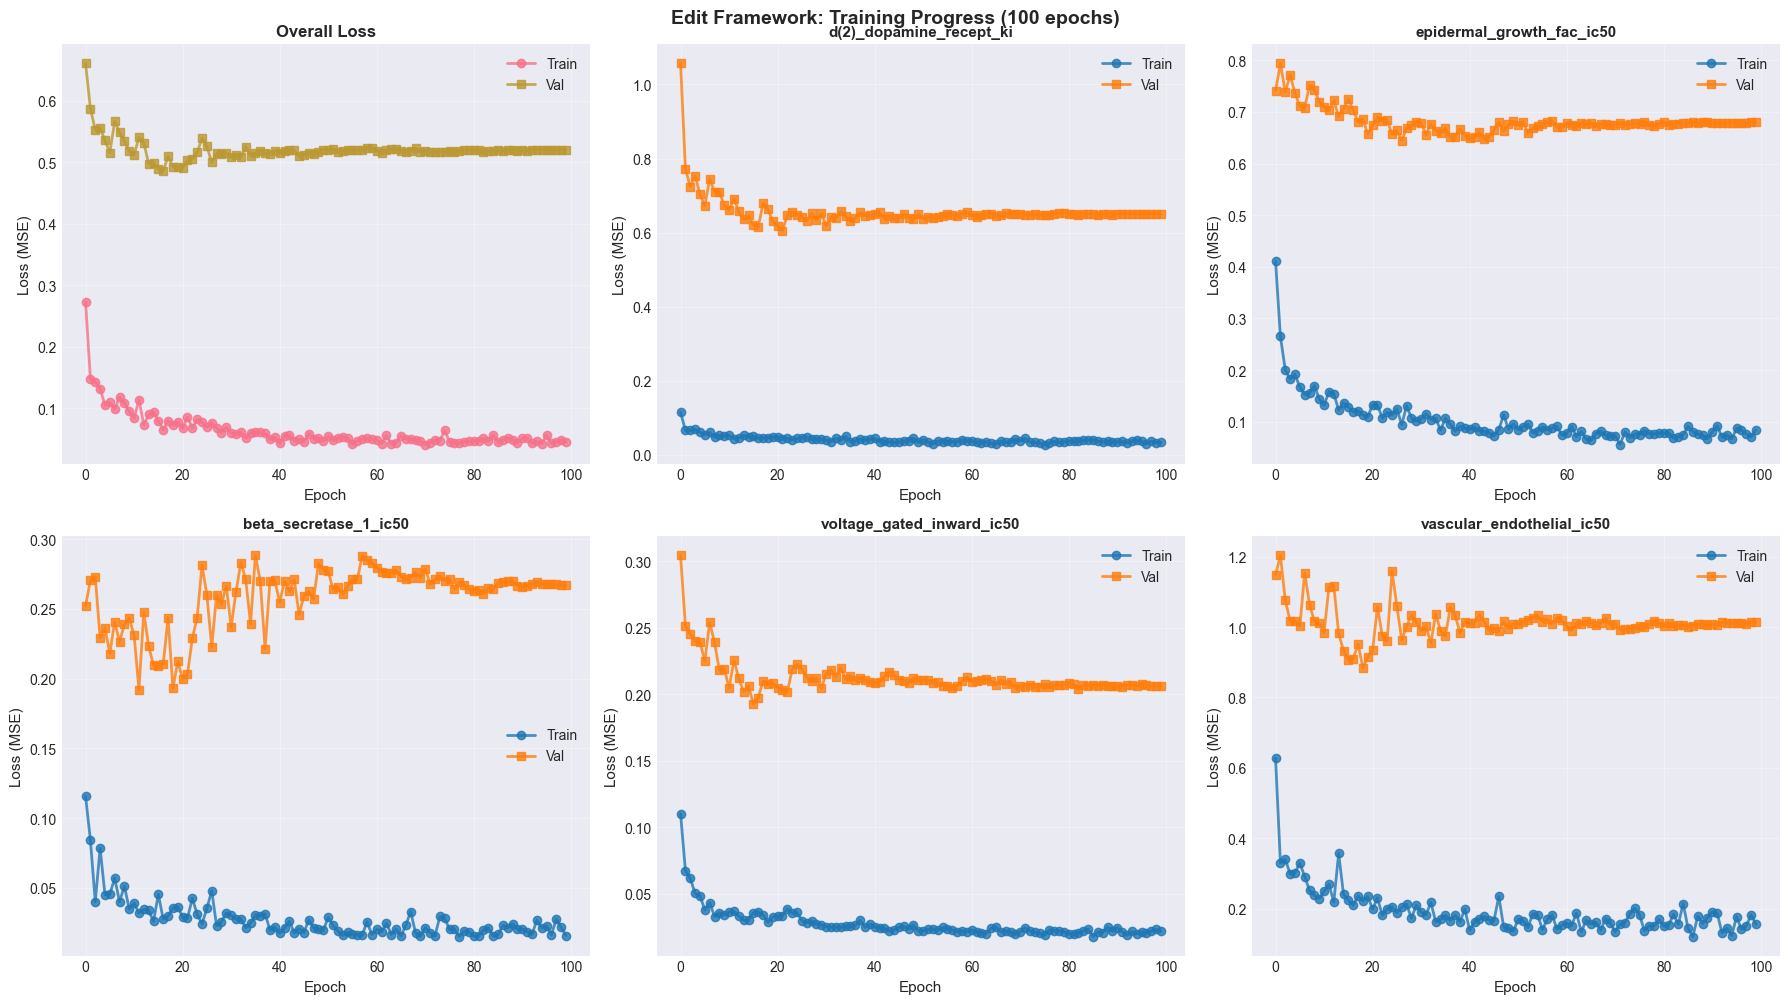


✓ Training history visualized (100 epochs)


In [34]:
# Visualize Edit Framework training progress per epoch
from scripts.plot_training_progress import plot_training_progress_per_epoch

fig, n_epochs = plot_training_progress_per_epoch(
    model=edit_model,
    task_names=selected_properties,
    steps_per_epoch=None  # Auto-calculated
)

if fig is not None:
    plt.suptitle(f'Edit Framework: Training Progress ({n_epochs} epochs)',
                fontsize=14, fontweight='bold', y=1.00)
    plt.show()
    print(f"\n✓ Training history visualized ({n_epochs} epochs)")


## 5. Train Baseline (Multi-Task Property Predictor)

In [16]:
# Baseline: Load or Train

# Try to load existing model
if BASELINE_MODEL_PATH and os.path.exists(BASELINE_MODEL_PATH):
    print(f"Loading Baseline from: {BASELINE_MODEL_PATH}")
    baseline_model = PropertyPredictor.load_checkpoint(
        BASELINE_MODEL_PATH,
        embedder=mol_embedder,
        device=device
    )
    print("✓ Baseline loaded successfully")
else:
    if BASELINE_MODEL_PATH:
        print(f"Model not found at {BASELINE_MODEL_PATH}, training from scratch...")
    else:
        print("Training Baseline from scratch...")

    # Train Baseline with pre-computed embeddings
    baseline_model = PropertyPredictor(
        embedder=mol_embedder,
        task_names=selected_properties,
        hidden_dims=HIDDEN_DIMS,
        dropout=DROPOUT,
        learning_rate=LEARNING_RATE,
        batch_size=BATCH_SIZE,
        max_epochs=MAX_EPOCHS,
        device=device
    )
    print("\nTraining Baseline with pre-computed embeddings...")
    baseline_model.fit(
        mol_emb_train=mol_emb_baseline_train,
        y_train=y_train_baseline,
        mol_emb_val=mol_emb_baseline_val,
        y_val=y_val_baseline
    )
    print("\n✓ Baseline trained using cached embeddings")

    # Save model if requested (FIXED: using save_checkpoint instead of torch.save)
    if SAVE_MODELS:
        save_path = BASELINE_MODEL_PATH if BASELINE_MODEL_PATH else os.path.join(MODELS_DIR, "baseline_property_predictor.pt")
        print(f"\nSaving Baseline to: {save_path}")
        baseline_model.save_checkpoint(save_path)
        print("✓ Model saved successfully")


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | multi_task_network | MultiTaskNetwork | 1.2 M  | train
----------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.971     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Training Baseline from scratch...

Training Baseline with pre-computed embeddings...
Using pre-computed embeddings for 284854 training molecules
Using pre-computed embeddings for 67954 validation molecules

Model architecture:
  EMBEDDER: Morgan Fingerprint
  Molecule embedding size: 2048
  Molecule embedder: chemprop_v2_morgan_r2_l2048_chiral
  Predictor input: 2048
  Shared backbone: [512, 256, 128, 64]
  Multi-task heads: 10 tasks
    → d(2)_dopamine_recept_ki
    → epidermal_growth_fac_ic50
    → beta_secretase_1_ic50
    → voltage_gated_inward_ic50
    → vascular_endothelial_ic50
    → voltage_gated_inward_ki
    → d(2)_dopamine_recept_ic50
    → tyrosine_protein_kin_ic50
    → beta_secretase_1_ki
    → vascular_endothelial_ki
  Total parameters: 1,242,698

Training for up to 100 epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Training complete!

✓ Baseline trained using cached embeddings

Saving Baseline to: ../models/baseline_property_predictor.pt
✓ Model saved successfully


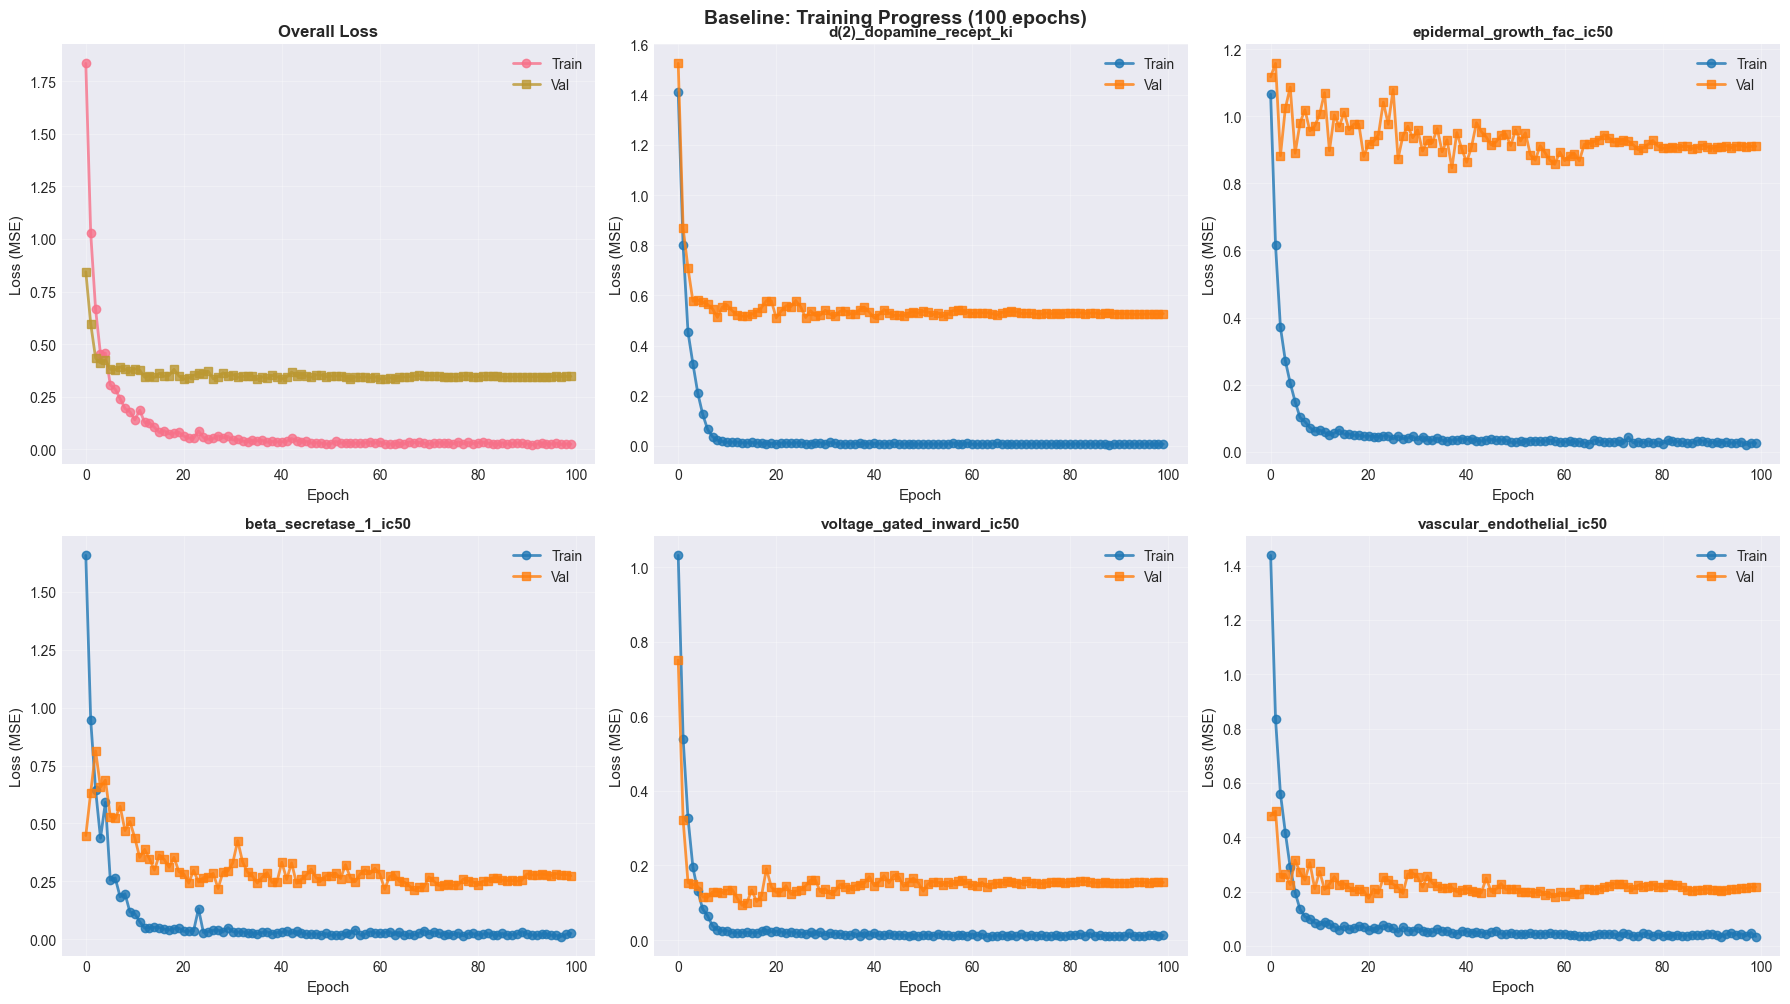


✓ Training history visualized (100 epochs)


In [17]:
# Visualize Baseline training progress per epoch
from scripts.plot_training_progress import plot_training_progress_per_epoch

fig, n_epochs = plot_training_progress_per_epoch(
    model=baseline_model,
    task_names=selected_properties,
    steps_per_epoch=None  # Auto-calculated
)

if fig is not None:
    plt.suptitle(f'Baseline: Training Progress ({n_epochs} epochs)',
                fontsize=14, fontweight='bold', y=1.00)
    plt.show()
    print(f"\n✓ Training history visualized ({n_epochs} epochs)")


### 5.1 Baseline Training Progress

## 6. Evaluation & Comparison


Evaluating Edit Framework (Mode 2: Edit Fragments)

  d(2)_dopamine_recept_ki
    N:      5481
    MSE:  0.6027
    RMSE: 0.7764
    MAE:  0.5369
    R²:   -0.0718

  epidermal_growth_fac_ic50
    N:      3902
    MSE:  0.4965
    RMSE: 0.7046
    MAE:  0.5595
    R²:   0.5866

  beta_secretase_1_ic50
    N:      1132
    MSE:  0.4899
    RMSE: 0.6999
    MAE:  0.5411
    R²:   -0.2134

  voltage_gated_inward_ic50
    N:      6392
    MSE:  0.1658
    RMSE: 0.4072
    MAE:  0.2541
    R²:   0.7881

  vascular_endothelial_ic50
    N:      4424
    MSE:  0.8815
    RMSE: 0.9389
    MAE:  0.7221
    R²:   0.5445

  voltage_gated_inward_ki
    N:      2113
    MSE:  0.1296
    RMSE: 0.3600
    MAE:  0.2303
    R²:   0.6362

  d(2)_dopamine_recept_ic50
    N:       185
    MSE:  0.2375
    RMSE: 0.4874
    MAE:  0.3982
    R²:   0.6166

  tyrosine_protein_kin_ic50
    N:       159
    MSE:  0.3199
    RMSE: 0.5656
    MAE:  0.3533
    R²:   -0.8008

  beta_secretase_1_ki
    N:       863
 

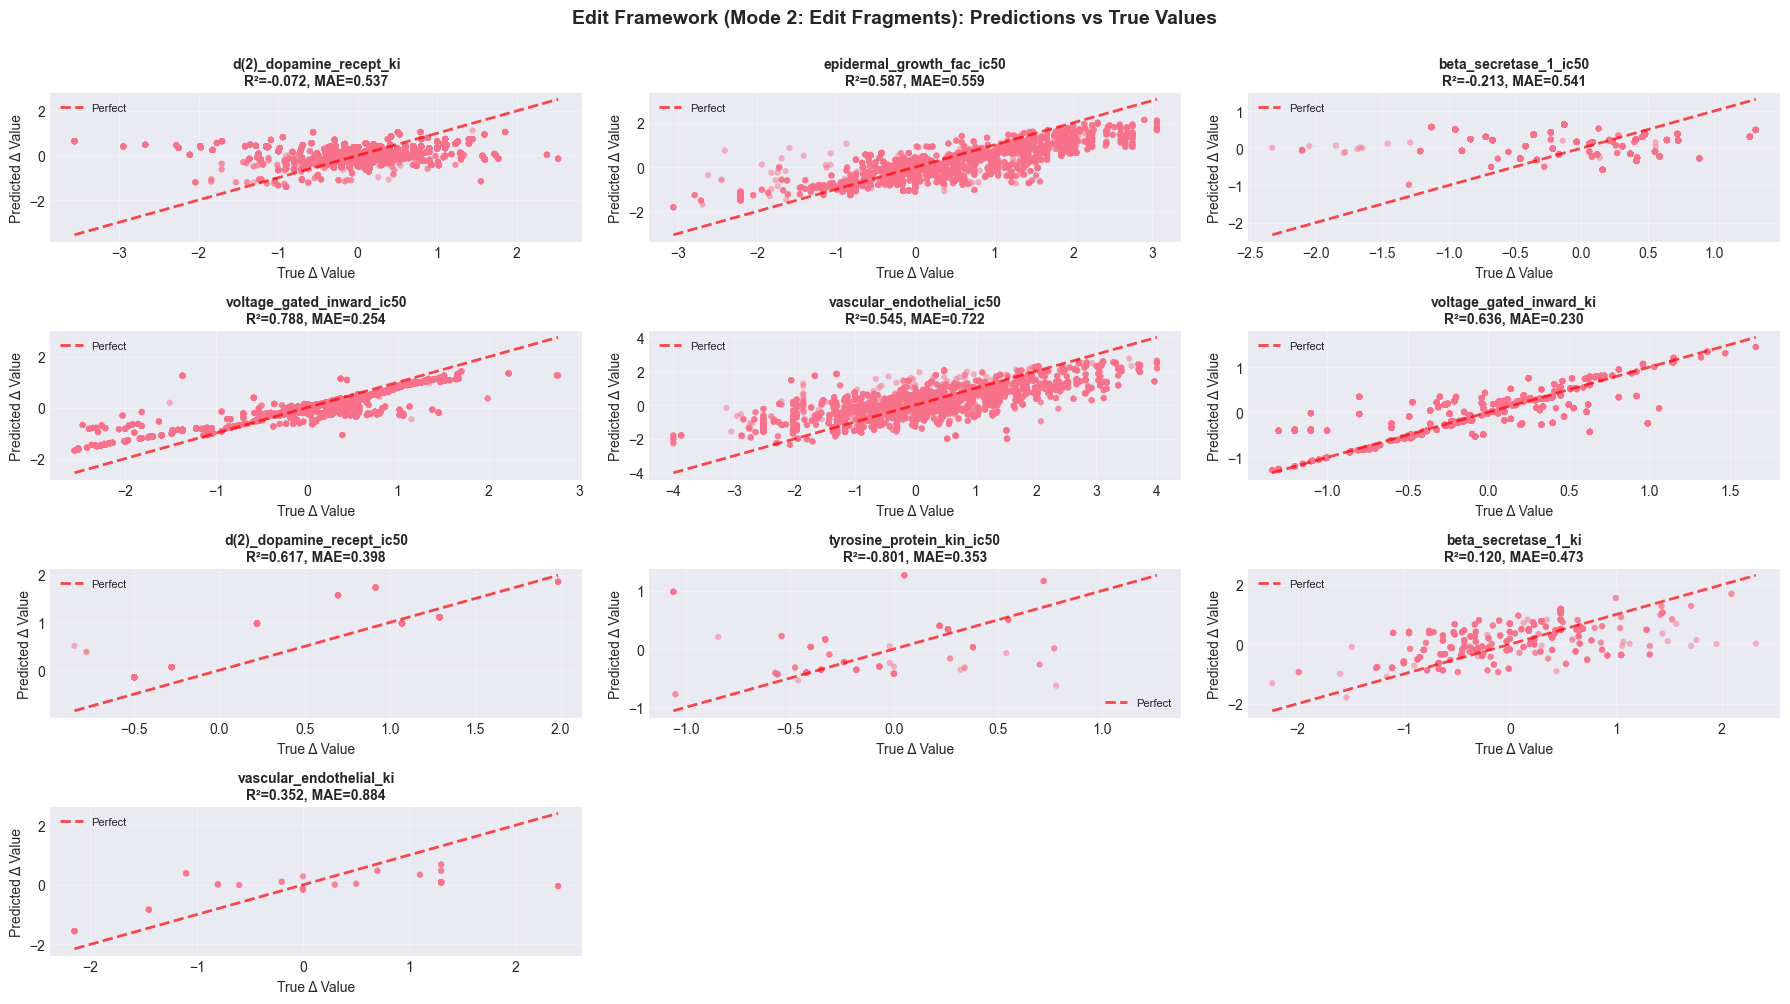

In [35]:
# Evaluate Edit Framework with pre-computed embeddings
import torch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

print("\n" + "="*70)
print("Evaluating Edit Framework (Mode 2: Edit Fragments)")
print("="*70)

# Get predictions using the model directly (since it uses trainable edit fragments)
edit_model.model.eval()
edit_model.model.to(edit_model.device)

with torch.no_grad():
    mol_a_tensor = torch.FloatTensor(mol_emb_a_test).to(edit_model.device)
    mol_b_tensor = torch.FloatTensor(mol_emb_b_test).to(edit_model.device)
    edit_frag_a_tensor = torch.FloatTensor(edit_frag_a_test).to(edit_model.device)
    edit_frag_b_tensor = torch.FloatTensor(edit_frag_b_test).to(edit_model.device)
    
    # Forward pass with edit fragments (Mode 2)
    edit_input = (mol_a_tensor, mol_b_tensor, edit_frag_a_tensor, edit_frag_b_tensor)
    predictions = edit_model.model(mol_a_tensor, edit_input)

# Convert predictions dict to arrays
pred_array = torch.stack([predictions[task] for task in selected_properties], dim=1).cpu().numpy()

# Get true labels
n_samples = len(test_edit)
n_tasks = len(selected_properties)
y_test = np.full((n_samples, n_tasks), np.nan)

for idx, row in test_edit.iterrows():
    prop_idx = int(row['property_idx'])
    y_test[idx, prop_idx] = row['delta']

# Calculate metrics per task
edit_metrics = []
edit_predictions = {}

for i, task_name in enumerate(selected_properties):
    y_true = y_test[:, i]
    y_pred = pred_array[:, i]
    
    # Filter out NaN values
    mask = ~np.isnan(y_true)
    y_true_valid = y_true[mask]
    y_pred_valid = y_pred[mask]
    
    if len(y_true_valid) == 0:
        continue
    
    # Calculate metrics
    mse = mean_squared_error(y_true_valid, y_pred_valid)
    mae = mean_absolute_error(y_true_valid, y_pred_valid)
    r2 = r2_score(y_true_valid, y_pred_valid)
    
    edit_metrics.append({
        'Task': task_name[:40],
        'N': len(y_true_valid),
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'MAE': mae,
        'R²': r2
    })
    
    edit_predictions[task_name] = (y_true_valid, y_pred_valid)
    
    print(f"\n  {task_name[:40]}")
    print(f"    N:    {len(y_true_valid):>6}")
    print(f"    MSE:  {mse:>6.4f}")
    print(f"    RMSE: {np.sqrt(mse):>6.4f}")
    print(f"    MAE:  {mae:>6.4f}")
    print(f"    R²:   {r2:>6.4f}")

edit_metrics = pd.DataFrame(edit_metrics)

# Overall metrics
print(f"\n{'='*70}")
print(f"Overall (Macro Average)")
print(f"{'='*70}")
print(f"  MSE:  {edit_metrics['MSE'].mean():.4f}")
print(f"  RMSE: {edit_metrics['RMSE'].mean():.4f}")
print(f"  MAE:  {edit_metrics['MAE'].mean():.4f}")
print(f"  R²:   {edit_metrics['R²'].mean():.4f}")
print(f"{'='*70}\n")

# Scatter plots
from scripts.evaluate_model import plot_predictions_scatter
fig = plot_predictions_scatter(
    predictions_dict=edit_predictions,
    model_name="Edit Framework (Mode 2: Edit Fragments)",
    figsize=(18, 10)
)
plt.show()



Evaluating Property Predictor (Baseline)
Using pre-computed embeddings for evaluation

  d(2)_dopamine_recept_ki
    N:     10962
    MSE:  1.4462
    RMSE: 1.2026
    MAE:  0.7617
    R²:   -0.1336

  epidermal_growth_fac_ic50
    N:      7804
    MSE:  0.3632
    RMSE: 0.6027
    MAE:  0.2760
    R²:   0.6549

  beta_secretase_1_ic50
    N:      2264
    MSE:  0.4459
    RMSE: 0.6677
    MAE:  0.4893
    R²:   -0.1766

  voltage_gated_inward_ic50
    N:     12784
    MSE:  0.1160
    RMSE: 0.3406
    MAE:  0.1664
    R²:   0.7544

  vascular_endothelial_ic50
    N:      8848
    MSE:  0.3028
    RMSE: 0.5502
    MAE:  0.2298
    R²:   0.7781

  voltage_gated_inward_ki
    N:      4226
    MSE:  0.1317
    RMSE: 0.3629
    MAE:  0.1893
    R²:   0.4081

  d(2)_dopamine_recept_ic50
    N:       370
    MSE:  0.4980
    RMSE: 0.7057
    MAE:  0.3744
    R²:   0.2270

  tyrosine_protein_kin_ic50
    N:       318
    MSE:  0.5094
    RMSE: 0.7137
    MAE:  0.4138
    R²:   0.5046

  beta

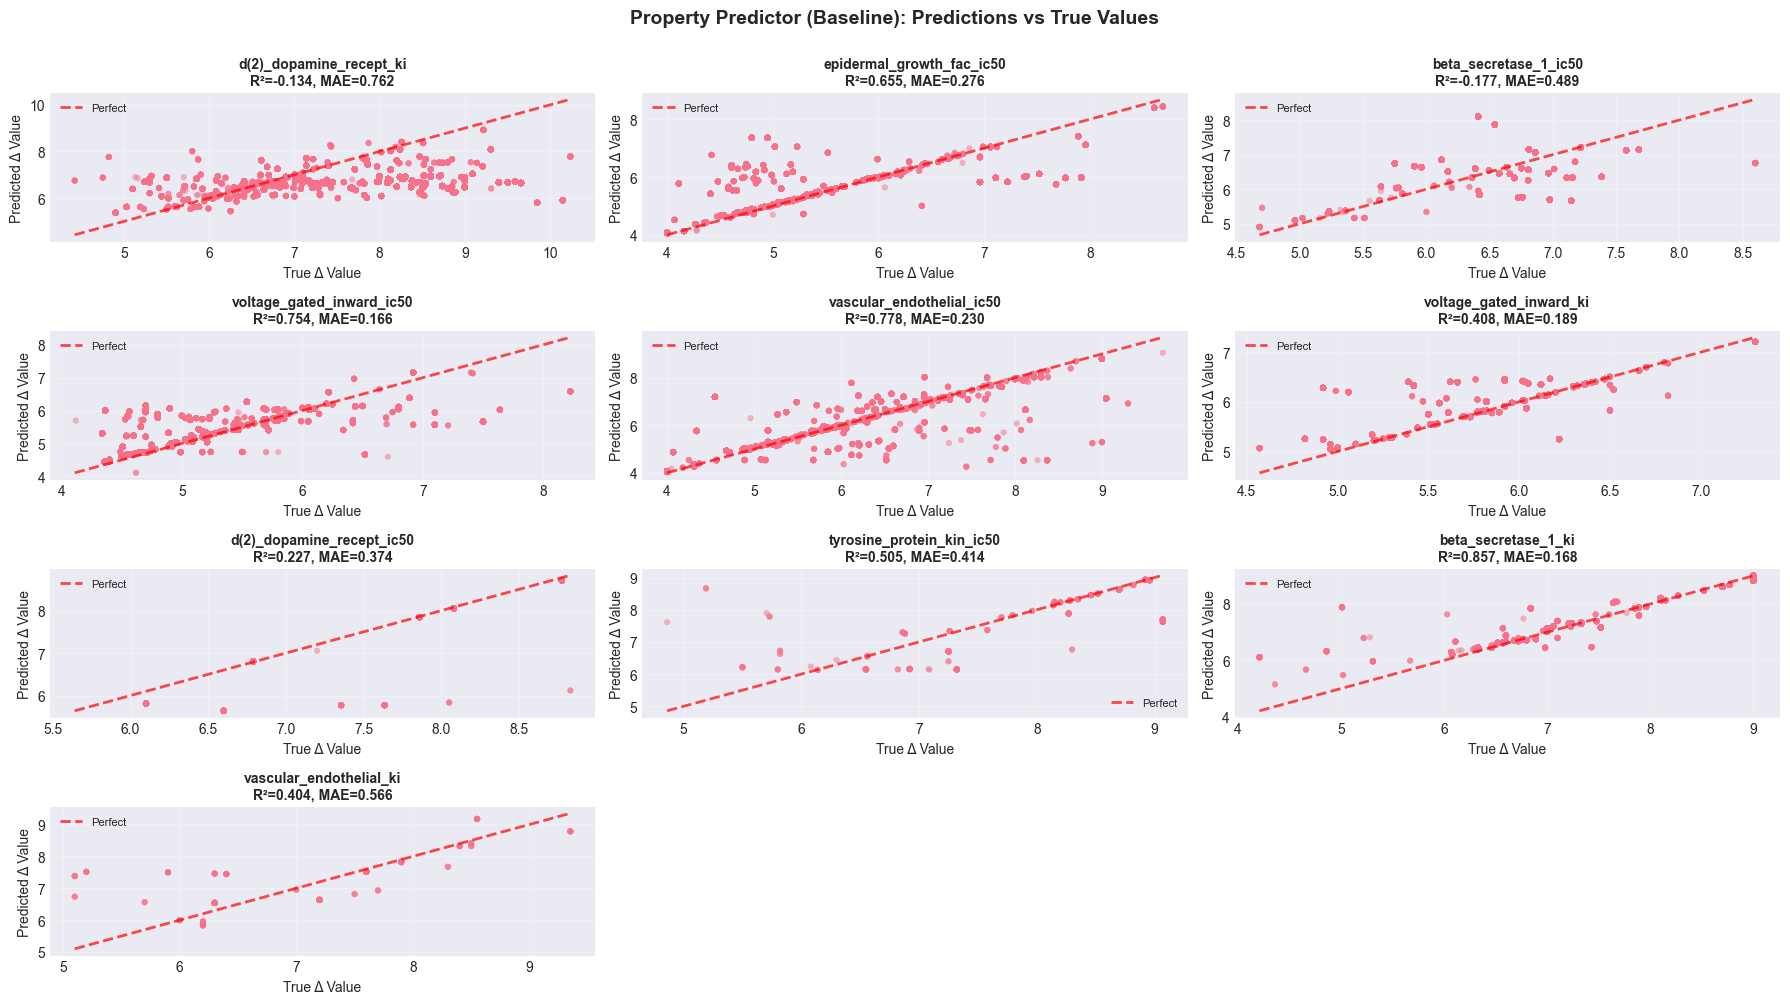

In [36]:
# Evaluate Baseline with pre-computed embeddings
from scripts.evaluate_model import evaluate_multi_task_model, plot_predictions_scatter

baseline_metrics, baseline_predictions = evaluate_multi_task_model(
    model=baseline_model,
    test_data=test_baseline,
    task_names=selected_properties,
    model_name="Property Predictor (Baseline)",
    mol_emb=mol_emb_baseline_test
)

# Scatter plots
fig = plot_predictions_scatter(
    predictions_dict=baseline_predictions,
    model_name="Property Predictor (Baseline)",
    figsize=(18, 10)
)
plt.show()


Calculating Mean Predictor baseline metrics...
✓ Mean Predictor metrics calculated for 10 tasks

CREATING THREE-WAY COMPARISON PLOTS

Generating MAE comparison...


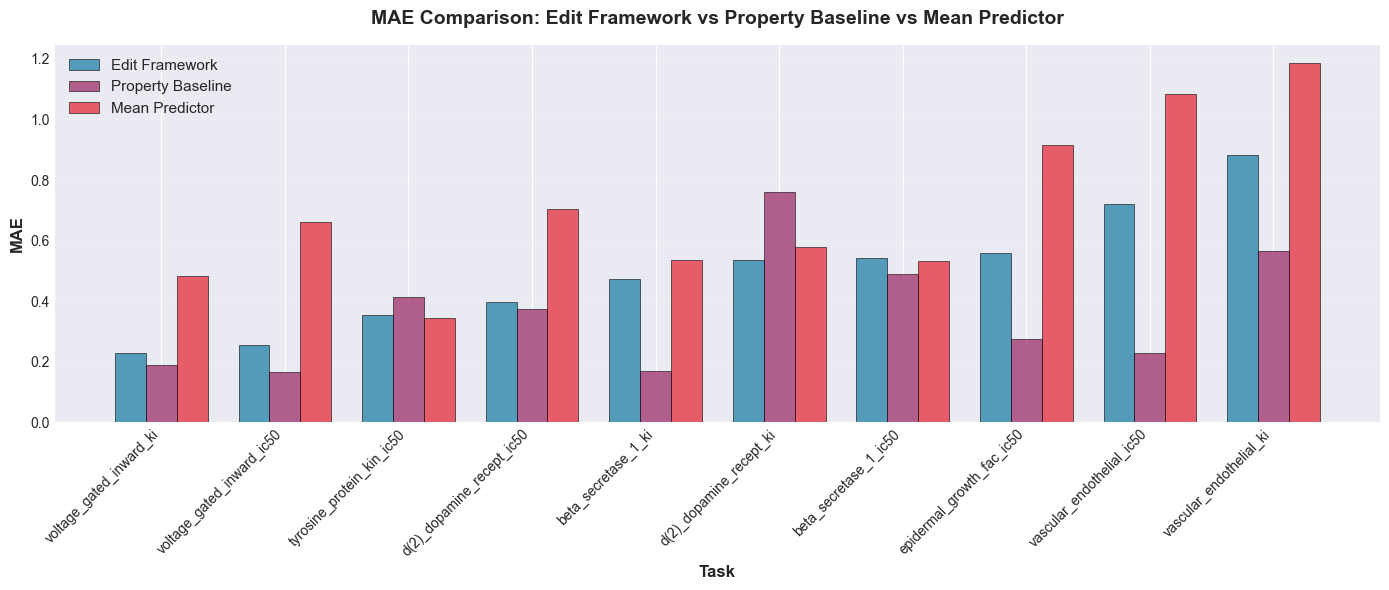

Generating MSE comparison...


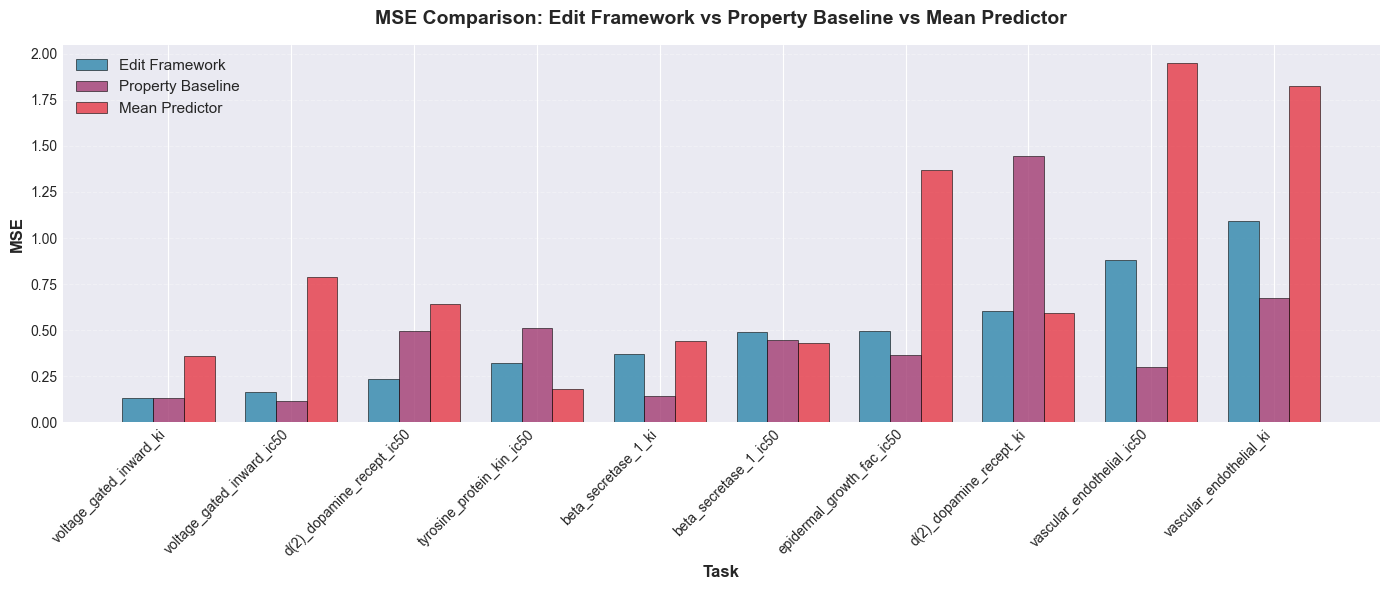

Generating R² comparison...


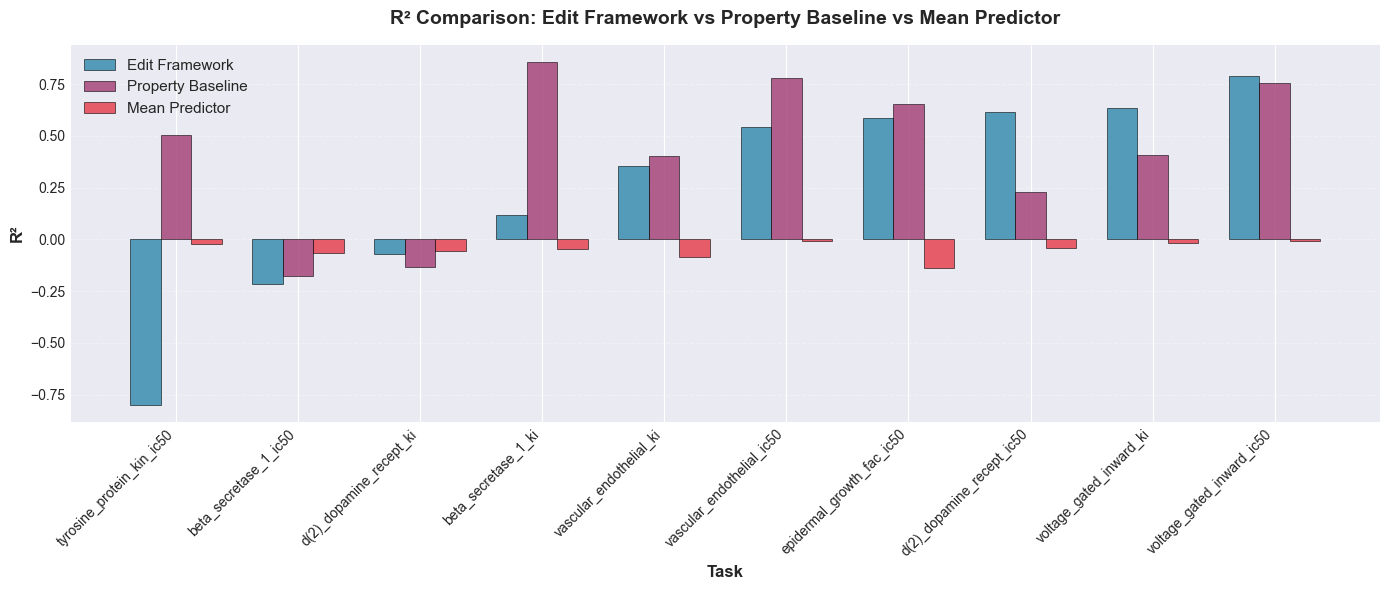


SUMMARY: Edit Framework vs Property Baseline vs Mean Predictor

Model                              MSE          MAE           R²
--------------------------------------------------------------------------------
Edit Framework                  0.4786       0.4953       0.2558
Property Baseline               0.4632       0.3634       0.4278
Mean Predictor                  0.8588       0.7035      -0.0487

--------------------------------------------------------------------------------
Edit Framework Improvements:
--------------------------------------------------------------------------------

Vs Property Baseline:
  MSE improvement:      -3.3%
  MAE improvement:     -36.3%
  R² improvement:    -0.1719

Vs Mean Predictor:
  MSE improvement:      44.3%
  MAE improvement:      29.6%
  R² improvement:     0.3045

✓ Three-way comparison complete!


In [37]:
# ==============================================================================
# THREE-WAY MODEL COMPARISON: Edit Framework vs Baseline vs Mean Predictor
# ==============================================================================

# Calculate Mean Predictor baseline metrics
# This baseline simply predicts the mean delta for each property
print("Calculating Mean Predictor baseline metrics...")

mean_predictor_metrics = []

for i, task_name in enumerate(selected_properties):
    # Get test data for this task (property_idx corresponds to position in selected_properties)
    task_test = test_edit[test_edit['property_idx'] == i]

    if len(task_test) == 0:
        continue

    # Get true values
    y_true = task_test['delta'].values

    # Predict the mean (train mean) for all test samples
    task_train = train_edit[train_edit['property_idx'] == i]
    y_pred_mean = np.full_like(y_true, task_train['delta'].mean())

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred_mean)
    mae = mean_absolute_error(y_true, y_pred_mean)
    r2 = r2_score(y_true, y_pred_mean)

    mean_predictor_metrics.append({
        'Task': task_name,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    })

mean_predictor_metrics = pd.DataFrame(mean_predictor_metrics)

print(f"✓ Mean Predictor metrics calculated for {len(mean_predictor_metrics)} tasks")

# ==============================================================================
# UPDATED COMPARISON FUNCTION WITH 3 MODELS
# ==============================================================================

def compare_three_models(
    metrics_1, metrics_2, metrics_3,
    name_1="Edit Framework", name_2="Baseline", name_3="Mean Predictor",
    metric='MAE',
    figsize=(14, 6),
    colors=None
):
    """
    Compare three models side-by-side.

    Args:
        metrics_1, metrics_2, metrics_3: DataFrames with columns ['Task', metric]
        name_1, name_2, name_3: Model names
        metric: Metric to compare ('MAE', 'MSE', or 'R²')
        figsize: Figure size
        colors: List of 3 colors [color1, color2, color3].
                Default: ['#2E86AB' (blue), '#A23B72' (purple), '#E63946' (red)]

    Returns:
        matplotlib.figure.Figure
    """
    if colors is None:
        colors = ['#2E86AB', '#A23B72', '#E63946']  # Blue, Purple, Red

    fig, ax = plt.subplots(figsize=figsize)

    # Merge metrics
    merged = metrics_1[['Task', metric]].merge(
        metrics_2[['Task', metric]], on='Task', suffixes=('_1', '_2')
    ).merge(
        metrics_3[['Task', metric]], on='Task'
    )
    merged.columns = ['Task', name_1, name_2, name_3]

    # Sort by first model's performance
    merged = merged.sort_values(name_1)

    # Create grouped bar chart
    x = np.arange(len(merged))
    width = 0.25

    bars1 = ax.bar(x - width, merged[name_1], width, label=name_1,
                   color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, merged[name_2], width, label=name_2,
                   color=colors[1], alpha=0.8, edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, merged[name_3], width, label=name_3,
                   color=colors[2], alpha=0.8, edgecolor='black', linewidth=0.5)

    # Customize
    ax.set_xlabel('Task', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison: {name_1} vs {name_2} vs {name_3}',
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(merged['Task'], rotation=45, ha='right')
    ax.legend(fontsize=11, framealpha=0.9, loc='best')
    ax.grid(alpha=0.3, linestyle='--', axis='y')

    plt.tight_layout()
    return fig

# ==============================================================================
# VISUALIZATIONS
# ==============================================================================

print("\n" + "="*80)
print("CREATING THREE-WAY COMPARISON PLOTS")
print("="*80)

# MAE comparison
print("\nGenerating MAE comparison...")
fig = compare_three_models(
    metrics_1=edit_metrics,
    metrics_2=baseline_metrics,
    metrics_3=mean_predictor_metrics,
    name_1="Edit Framework",
    name_2="Property Baseline",
    name_3="Mean Predictor",
    metric='MAE',
    figsize=(14, 6)
)
plt.show()

# MSE comparison
print("Generating MSE comparison...")
fig = compare_three_models(
    metrics_1=edit_metrics,
    metrics_2=baseline_metrics,
    metrics_3=mean_predictor_metrics,
    name_1="Edit Framework",
    name_2="Property Baseline",
    name_3="Mean Predictor",
    metric='MSE',
    figsize=(14, 6)
)
plt.show()

# R² comparison
print("Generating R² comparison...")
fig = compare_three_models(
    metrics_1=edit_metrics,
    metrics_2=baseline_metrics,
    metrics_3=mean_predictor_metrics,
    name_1="Edit Framework",
    name_2="Property Baseline",
    name_3="Mean Predictor",
    metric='R²',
    figsize=(14, 6)
)
plt.show()

# ==============================================================================
# SUMMARY STATISTICS
# ==============================================================================

# Calculate summary metrics
avg_mse_edit = edit_metrics['MSE'].mean()
avg_mse_baseline = baseline_metrics['MSE'].mean()
avg_mse_mean = mean_predictor_metrics['MSE'].mean()

avg_mae_edit = edit_metrics['MAE'].mean()
avg_mae_baseline = baseline_metrics['MAE'].mean()
avg_mae_mean = mean_predictor_metrics['MAE'].mean()

avg_r2_edit = edit_metrics['R²'].mean()
avg_r2_baseline = baseline_metrics['R²'].mean()
avg_r2_mean = mean_predictor_metrics['R²'].mean()

# Calculate improvements
mse_improvement_vs_baseline = ((avg_mse_baseline - avg_mse_edit) / avg_mse_baseline) * 100
mse_improvement_vs_mean = ((avg_mse_mean - avg_mse_edit) / avg_mse_mean) * 100

mae_improvement_vs_baseline = ((avg_mae_baseline - avg_mae_edit) / avg_mae_baseline) * 100
mae_improvement_vs_mean = ((avg_mae_mean - avg_mae_edit) / avg_mae_mean) * 100

r2_improvement_vs_baseline = avg_r2_edit - avg_r2_baseline
r2_improvement_vs_mean = avg_r2_edit - avg_r2_mean

# Print summary
print("\n" + "="*80)
print("SUMMARY: Edit Framework vs Property Baseline vs Mean Predictor")
print("="*80)

print(f"\n{'Model':<25} {'MSE':>12} {'MAE':>12} {'R²':>12}")
print("-" * 80)
print(f"{'Edit Framework':<25} {avg_mse_edit:>12.4f} {avg_mae_edit:>12.4f} {avg_r2_edit:>12.4f}")
print(f"{'Property Baseline':<25} {avg_mse_baseline:>12.4f} {avg_mae_baseline:>12.4f} {avg_r2_baseline:>12.4f}")
print(f"{'Mean Predictor':<25} {avg_mse_mean:>12.4f} {avg_mae_mean:>12.4f} {avg_r2_mean:>12.4f}")

print("\n" + "-"*80)
print("Edit Framework Improvements:")
print("-" * 80)

print(f"\nVs Property Baseline:")
print(f"  MSE improvement:  {mse_improvement_vs_baseline:>8.1f}%")
print(f"  MAE improvement:  {mae_improvement_vs_baseline:>8.1f}%")
print(f"  R² improvement:   {r2_improvement_vs_baseline:>8.4f}")

print(f"\nVs Mean Predictor:")
print(f"  MSE improvement:  {mse_improvement_vs_mean:>8.1f}%")
print(f"  MAE improvement:  {mae_improvement_vs_mean:>8.1f}%")
print(f"  R² improvement:   {r2_improvement_vs_mean:>8.4f}")

print("\n" + "="*80)
print("✓ Three-way comparison complete!")
print("="*80)


## 7. Analyze Shared Edit Embeddings

In [38]:
# Extract unique edit embeddings from Edit Framework
print("Extracting unique edit embeddings...\n")

# Get edit layer
edit_layer = edit_model.model.trainable_edit_layer

# Use pre-computed embeddings (already encoded)
mol_a_tensor = torch.FloatTensor(mol_emb_a_test).to(device)
mol_b_tensor = torch.FloatTensor(mol_emb_b_test).to(device)

# Fragment embeddings (needed for Mode 2)
edit_frag_a_tensor = torch.FloatTensor(edit_frag_a_test).to(device)
edit_frag_b_tensor = torch.FloatTensor(edit_frag_b_test).to(device)

edit_layer.eval()
with torch.no_grad():
    all_edit_emb = edit_layer(mol_a_tensor, mol_b_tensor, edit_frag_a_tensor, edit_frag_b_tensor).cpu().numpy()

# Get unique edits - same edit always produces same embedding
# So we just need one embedding per unique edit name
unique_edits = test_edit['edit_name'].unique()
edit_to_idx = {edit: test_edit[test_edit['edit_name'] == edit].index[0] 
               for edit in unique_edits}

# Extract one embedding per unique edit
edit_embeddings = np.array([all_edit_emb[idx] for idx in edit_to_idx.values()])
edit_names = list(edit_to_idx.keys())

print(f"Total test pairs: {len(all_edit_emb)}")
print(f"Unique edits: {len(edit_names)}")
print(f"Edit embedding shape: {edit_embeddings.shape}")


Extracting unique edit embeddings...

Total test pairs: 24733
Unique edits: 2409
Edit embedding shape: (2409, 2048)


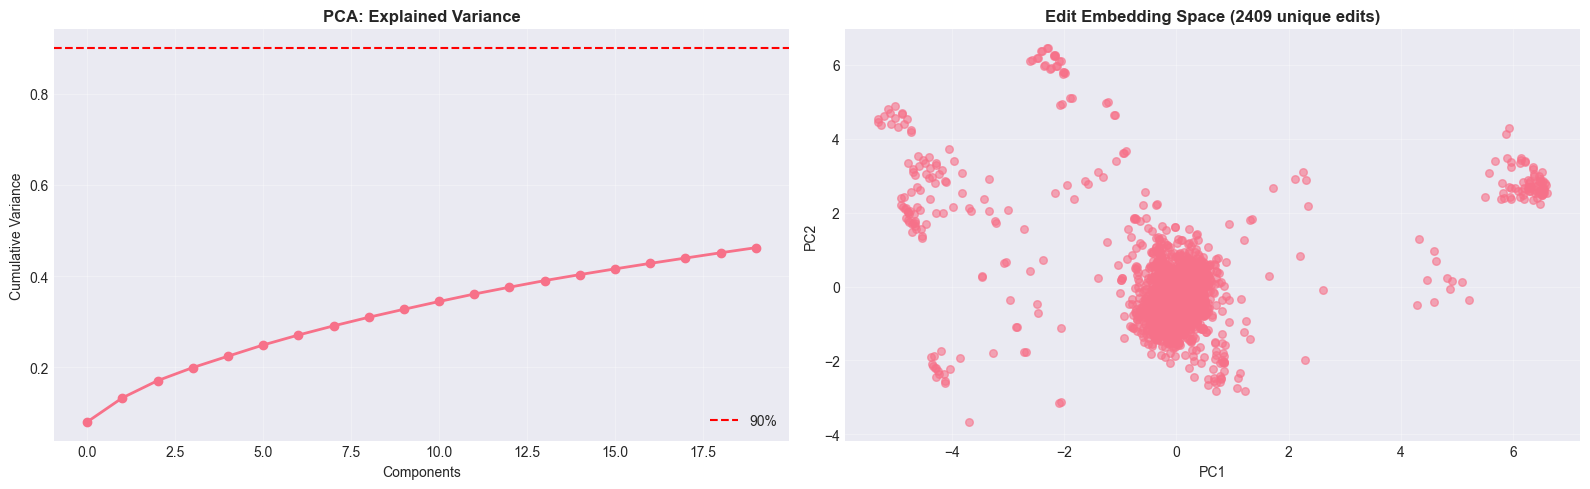


First 10 PCs: 32.7% variance
First 2 PCs: 13.3% variance


In [39]:
# PCA of unique edit embeddings
pca = PCA(n_components=min(50, edit_embeddings.shape[0]))
edit_pca = pca.fit_transform(edit_embeddings)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
ax1.plot(np.cumsum(pca.explained_variance_ratio_[:20]), 'o-', linewidth=2)
ax1.set_xlabel('Components')
ax1.set_ylabel('Cumulative Variance')
ax1.set_title('PCA: Explained Variance', fontweight='bold')
ax1.grid(alpha=0.3)
ax1.axhline(0.9, color='r', linestyle='--', label='90%')
ax1.legend()

# PC1 vs PC2 scatter
ax2.scatter(edit_pca[:, 0], edit_pca[:, 1], alpha=0.6, s=30)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title(f'Edit Embedding Space ({len(edit_names)} unique edits)', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFirst 10 PCs: {pca.explained_variance_ratio_[:10].sum():.1%} variance")
print(f"First 2 PCs: {pca.explained_variance_ratio_[:2].sum():.1%} variance")


K-MEANS CLUSTERING OF EDIT EMBEDDINGS

Data info:
  edit_pca.shape: (2409, 50)
  Total unique edits: 2409
  Unique edits in df_filtered: 9016

Performing K-Means with 4 clusters...
✓ Clustering complete
  Clusters: 4
  Total edits: 2409

CREATING VISUALIZATION WITH TOP EDIT LABELS


/var/folders/25/fhz0y4sn5s78bjb875173xfm0000gn/T/ipykernel_18327/256638986.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_cmap = cm.get_cmap('Set2')


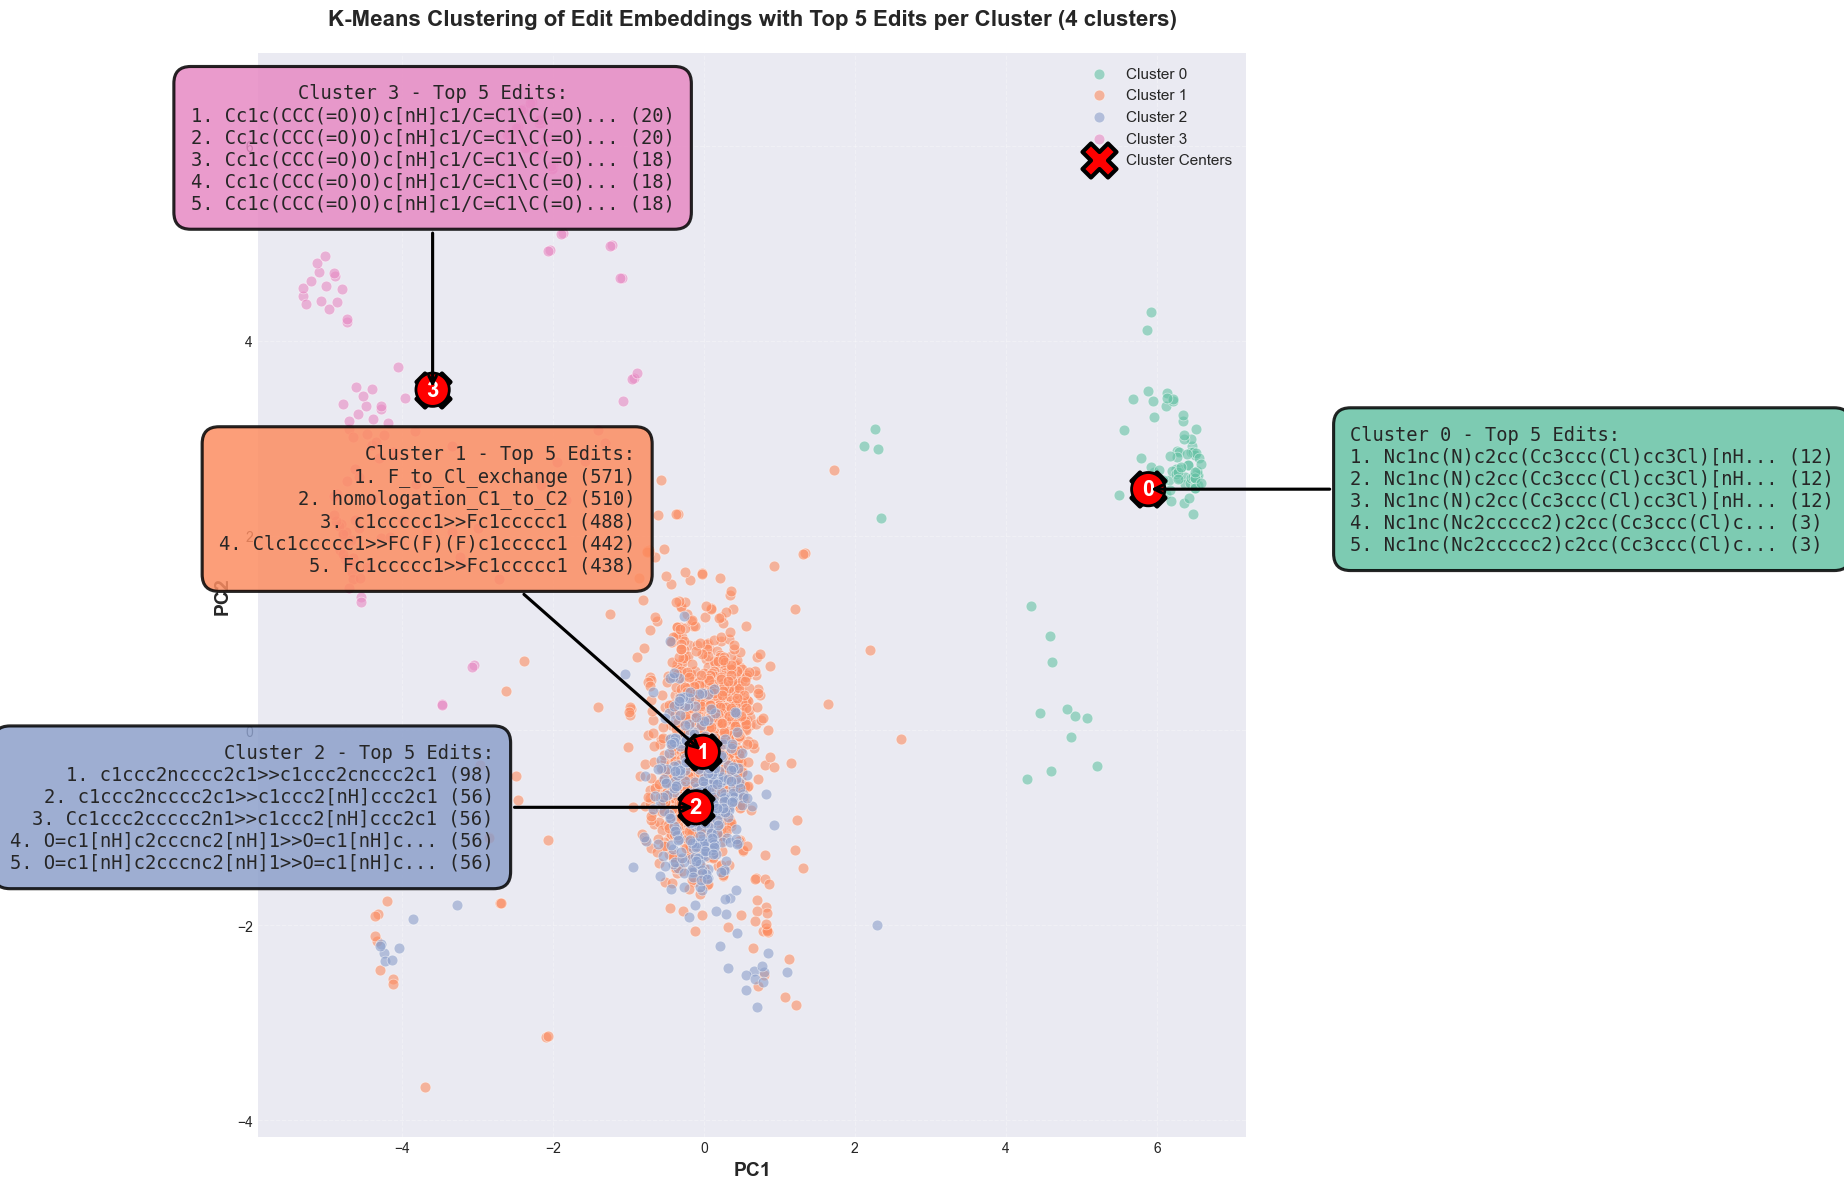


CLUSTER STATISTICS

Cluster ID         Size   % of Total
--------------------------------------------------------------------------------
0                    90         3.7%
1                  1841        76.4%
2                   348        14.4%
3                   130         5.4%

TOP 5 MOST COMMON EDITS IN EACH CLUSTER

────────────────────────────────────────────────────────────────────────────────
CLUSTER 0 (90 unique edits)
────────────────────────────────────────────────────────────────────────────────

Rank   Edit Name                                            Overall Count
--------------------------------------------------------------------------------
1      Nc1nc(N)c2cc(Cc3ccc(Cl)cc3Cl)[nH]c2n1>>COc1cc2c...              12
2      Nc1nc(N)c2cc(Cc3ccc(Cl)cc3Cl)[nH]c2n1>>COc1cc2c...              12
3      Nc1nc(N)c2cc(Cc3ccc(Cl)cc3Cl)[nH]c2n1>>COc1cc2c...              12
4      Nc1nc(Nc2ccccc2)c2cc(Cc3ccc(Cl)cc3Cl)[nH]c2n1>>...               3
5      Nc1nc(Nc2ccccc2)c2cc(C

In [40]:
# ==============================================================================
# K-MEANS CLUSTERING OF EDIT EMBEDDINGS WITH TOP EDITS LABELED
# ==============================================================================
# This cell:
# 1. Performs K-Means clustering on edit embeddings
# 2. Visualizes the 4 clusters in distinct colors
# 3. Shows the top 5 most common edits in each cluster
# 4. Labels the top 5 edits for each cluster on the plot at specified positions
# ==============================================================================

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

print("="*80)
print("K-MEANS CLUSTERING OF EDIT EMBEDDINGS")
print("="*80)

# Recreate the full edit_names list from edit_to_idx to match edit_embeddings
# edit_embeddings was created from edit_to_idx, so we need the same ordering
all_edit_names = list(edit_to_idx.keys())

print(f"\nData info:")
print(f"  edit_pca.shape: {edit_pca.shape}")
print(f"  Total unique edits: {len(all_edit_names)}")
print(f"  Unique edits in df_filtered: {df_filtered['edit_name'].nunique()}")

# Perform K-Means clustering
N_CLUSTERS = 4
print(f"\nPerforming K-Means with {N_CLUSTERS} clusters...")

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(edit_pca[:, :10])  # Use first 10 PCs

# Get cluster centers in the 10D space
cluster_centers = kmeans.cluster_centers_

print(f"✓ Clustering complete")
print(f"  Clusters: {N_CLUSTERS}")
print(f"  Total edits: {len(all_edit_names)}")

# ==============================================================================
# PREPARE TOP EDITS DATA
# ==============================================================================

# First, count overall edit frequencies across the dataset
overall_edit_counts = Counter(df_filtered['edit_name'])

# Group edits by cluster
cluster_edits = defaultdict(list)
for idx, (edit_name, cluster_id) in enumerate(zip(all_edit_names, cluster_labels)):
    cluster_edits[cluster_id].append(edit_name)

# Get top 5 edits per cluster
cluster_top_edits = {}
for cluster_id in range(N_CLUSTERS):
    edits_in_cluster = cluster_edits[cluster_id]

    # Get counts for these edits from the overall dataset
    edit_counts_in_cluster = []
    for edit in edits_in_cluster:
        count = overall_edit_counts.get(edit, 0)
        edit_counts_in_cluster.append((edit, count))

    # Sort by overall frequency (descending)
    edit_counts_in_cluster.sort(key=lambda x: x[1], reverse=True)

    # Store top 5
    cluster_top_edits[cluster_id] = edit_counts_in_cluster[:5]

# ==============================================================================
# VISUALIZATION WITH LABELS
# ==============================================================================

print("\n" + "="*80)
print("CREATING VISUALIZATION WITH TOP EDIT LABELS")
print("="*80)

fig, ax = plt.subplots(figsize=(18, 12))

# Plot each cluster in a different color
import matplotlib.cm as cm
cluster_cmap = cm.get_cmap('Set2')

for cluster_id in range(N_CLUSTERS):
    mask = cluster_labels == cluster_id
    ax.scatter(edit_pca[mask, 0], edit_pca[mask, 1],
               c=[cluster_cmap(cluster_id)], alpha=0.6, s=60,
               label=f'Cluster {cluster_id}',
               edgecolors='white', linewidth=0.5)

# Plot cluster centers
# Project centers to PC1 and PC2 space
from sklearn.decomposition import PCA as PCA_vis
pca_vis = PCA(n_components=2)
pca_vis.fit(edit_pca[:, :10])
centers_pc = pca_vis.transform(cluster_centers)

ax.scatter(centers_pc[:, 0], centers_pc[:, 1],
           c='red', marker='X', s=600, edgecolors='black',
           linewidth=3, label='Cluster Centers', zorder=10)

# Add cluster ID labels near centers
for cluster_id, (cx, cy) in enumerate(centers_pc):
    ax.annotate(f'{cluster_id}', xy=(cx, cy), fontsize=16, fontweight='bold',
               ha='center', va='center', color='white',
               bbox=dict(boxstyle='circle,pad=0.3', facecolor='red',
                        edgecolor='black', linewidth=2),
               zorder=11)

# ==============================================================================
# ADD TOP 5 EDIT LABELS FOR EACH CLUSTER
# ==============================================================================

# Define position offsets for each cluster
# Format: (horizontal_alignment, vertical_alignment, x_offset_factor, y_offset_factor)
label_positions = {
    0: ('left', 'center', 1.5, 0),      # Right side of cluster 0
    1: ('right', 'bottom', -0.5, 1.2),  # Top left of cluster 1
    2: ('right', 'center', -1.5, 0),    # Left side of cluster 2
    3: ('center', 'bottom', 0, 1.2)     # Above cluster 3
}

# Calculate axis ranges for offset calculations
x_range = edit_pca[:, 0].max() - edit_pca[:, 0].min()
y_range = edit_pca[:, 1].max() - edit_pca[:, 1].min()

for cluster_id in range(N_CLUSTERS):
    cx, cy = centers_pc[cluster_id]
    ha, va, x_offset_factor, y_offset_factor = label_positions[cluster_id]

    # Calculate offset position
    label_x = cx + (x_offset_factor * x_range * 0.15)
    label_y = cy + (y_offset_factor * y_range * 0.15)

    # Create label text with top 5 edits
    top_edits = cluster_top_edits[cluster_id]
    label_lines = [f"Cluster {cluster_id} - Top 5 Edits:"]
    for rank, (edit_name, count) in enumerate(top_edits, 1):
        # Truncate long edit names
        display_name = edit_name if len(edit_name) <= 35 else edit_name[:32] + "..."
        label_lines.append(f"{rank}. {display_name} ({count:,})")

    label_text = "\n".join(label_lines)

    # Add text box with top edits (150% larger)
    bbox_props = dict(
        boxstyle='round,pad=0.9',  # Increased padding from 0.6 to 0.9
        facecolor=cluster_cmap(cluster_id),
        alpha=0.85,
        edgecolor='black',
        linewidth=2.25  # Increased from 1.5 to 2.25 (150%)
    )

    ax.annotate(label_text, xy=(cx, cy), xytext=(label_x, label_y),
               fontsize=13.5, ha=ha, va=va,  # Increased from 9 to 13.5 (150%)
               bbox=bbox_props,
               arrowprops=dict(arrowstyle='->', lw=2.25, color='black'),  # Increased from 1.5 to 2.25
               zorder=12, family='monospace')

ax.set_xlabel('PC1', fontsize=14, fontweight='bold')
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')
ax.set_title(f'K-Means Clustering of Edit Embeddings with Top 5 Edits per Cluster ({N_CLUSTERS} clusters)',
             fontweight='bold', fontsize=16, pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.95,
         edgecolor='black', fancybox=True)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# ==============================================================================
# CLUSTER STATISTICS
# ==============================================================================

print("\n" + "="*80)
print("CLUSTER STATISTICS")
print("="*80)

print(f"\n{'Cluster ID':<12} {'Size':>10} {'% of Total':>12}")
print("-" * 80)

for cluster_id in range(N_CLUSTERS):
    mask = cluster_labels == cluster_id
    size = mask.sum()
    pct = 100 * size / len(cluster_labels)
    print(f"{cluster_id:<12} {size:>10} {pct:>11.1f}%")

# ==============================================================================
# TOP 5 MOST COMMON EDITS PER CLUSTER
# ==============================================================================

print("\n" + "="*80)
print("TOP 5 MOST COMMON EDITS IN EACH CLUSTER")
print("="*80)

# For each cluster, show top 5 most common edits (by overall frequency)
for cluster_id in range(N_CLUSTERS):
    edits_in_cluster = cluster_edits[cluster_id]

    print(f"\n{'─'*80}")
    print(f"CLUSTER {cluster_id} ({len(edits_in_cluster)} unique edits)")
    print(f"{'─'*80}")

    if len(edits_in_cluster) == 0:
        print("\n  (No edits in this cluster)")
        continue

    # Show top 5
    print(f"\n{'Rank':<6} {'Edit Name':<50} {'Overall Count':>15}")
    print("-" * 80)

    for rank, (edit_name, count) in enumerate(cluster_top_edits[cluster_id], 1):
        # Truncate long edit names for display
        display_name = edit_name if len(edit_name) <= 50 else edit_name[:47] + "..."
        print(f"{rank:<6} {display_name:<50} {count:>15,}")

    if len(edits_in_cluster) > 5:
        print(f"\n  ... and {len(edits_in_cluster) - 5} more edits in this cluster")

print("\n" + "="*80)
print("✓ K-Means clustering analysis complete!")
print("="*80)


FINDING MOST FREQUENT EDITS ACROSS DATASET

Total unique edits in dataset: 279064

Top 20 Most Frequent Edits Overall:
Rank   Edit Name                                               Count
--------------------------------------------------------------------------------
1      F_to_Cl_exchange                                          571
2      homologation_C1_to_C2                                     516
3      c1ccccc1>>Fc1ccccc1                                       514
4      Clc1ccccc1>>FC(F)(F)c1ccccc1                              462
5      Fc1ccccc1>>Fc1ccccc1                                      443
6      Fc1ccccc1>>FC(F)(F)c1ccccc1                               427
7      Fc1ccccc1C(F)(F)F>>Fc1cccc(C(F)(F)F)c1                    416
8      Fc1ccccc1>>Clc1ccccc1                                     394
9      Fc1ccccc1C(F)(F)F>>FC(F)(F)Oc1ccccc1                      384
10     Fc1ccccc1C(F)(F)F>>FS(F)(F)(F)(F)c1ccccc1                 372
11     Cl>>CO                            

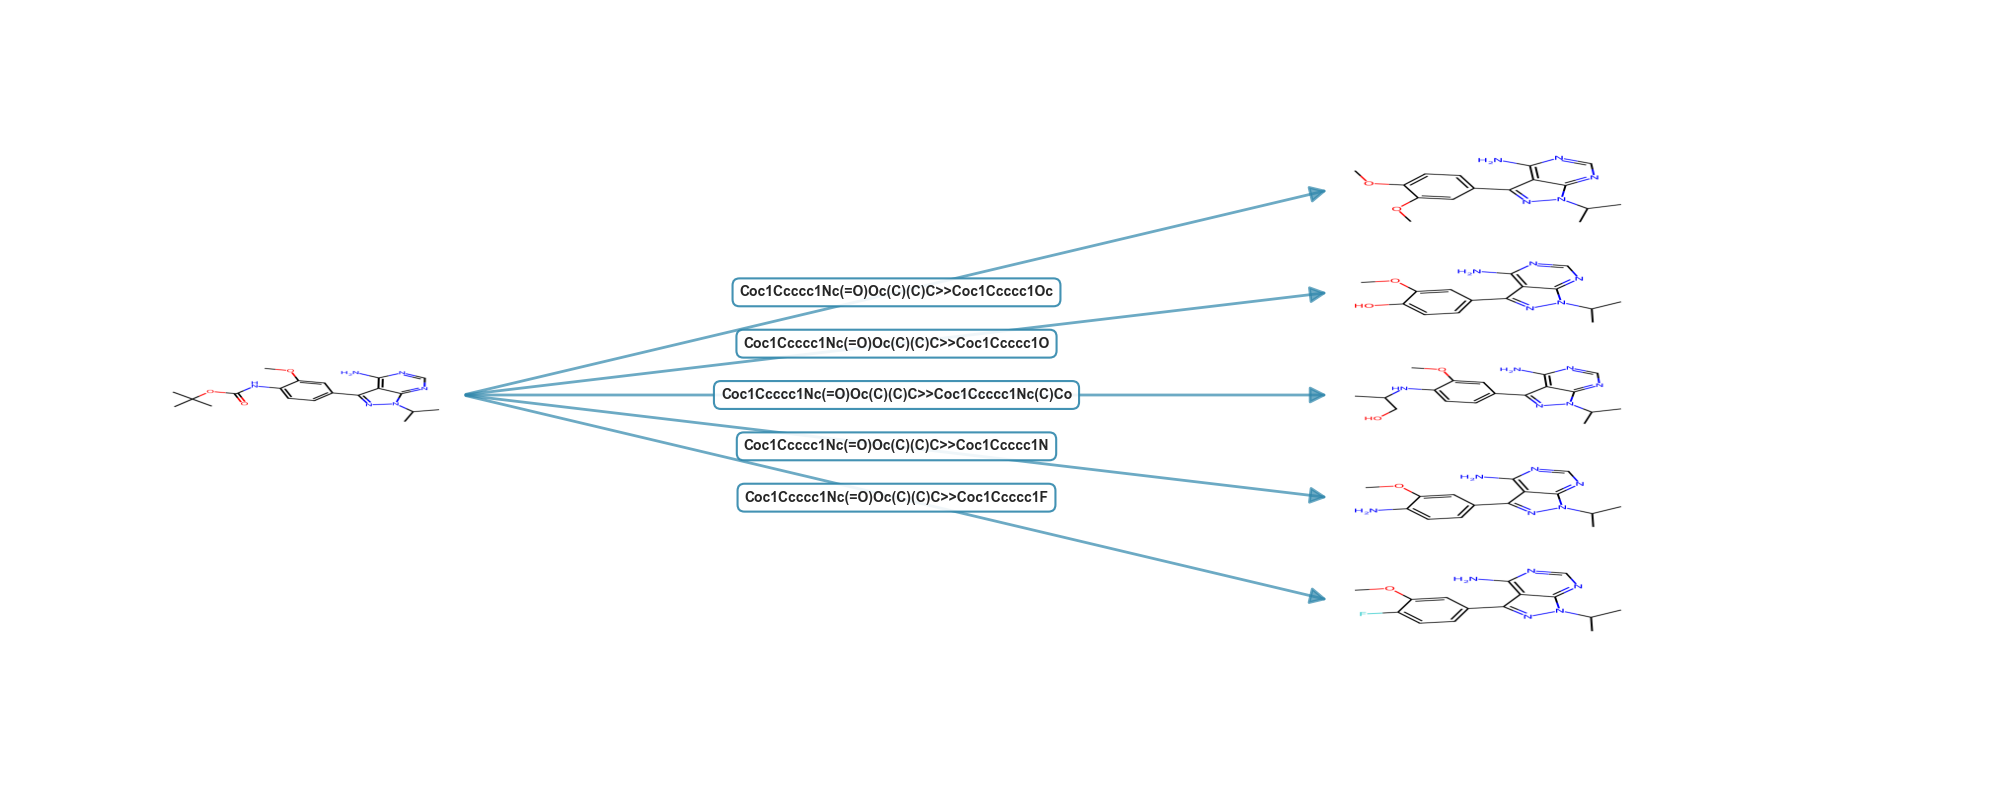


✓ Visualization 1 complete

MOLECULE 2
Source SMILES: COc1cc(Br)cc(-c2nn(C(C)C)c3ncnc(N)c23)c1

This molecule has 502 unique edits
Total transformations: 789

Top 5 most common edits (overall) performed on this molecule:
#    Edit Name                                      Overall Rank  Overall Count   On This Mol
----------------------------------------------------------------------------------------------------
1    CO>>O                                                  1480            157             8
     └─> Example: Δepidermal_growth_fac_ic50 =   1.64
2    COc1cccc(Br)c1>>c1ccc2cnccc2c1                        71294             16            16
     └─> Example: Δvascular_endothelial_ic50 =  -1.68
3    COc1cccc(Br)c1>>Cc1ccc2ccccc2n1                       71295              8             8
     └─> Example: Δvascular_endothelial_ic50 =  -1.99
4    CC(C)n1nc(-c2cccc(Br)c2)c2c(N)ncnc21>>COc1ccc(-c2nn(C(C)C)c3ncnc(N)c23)cc1         71296             10            10
     └─> Example

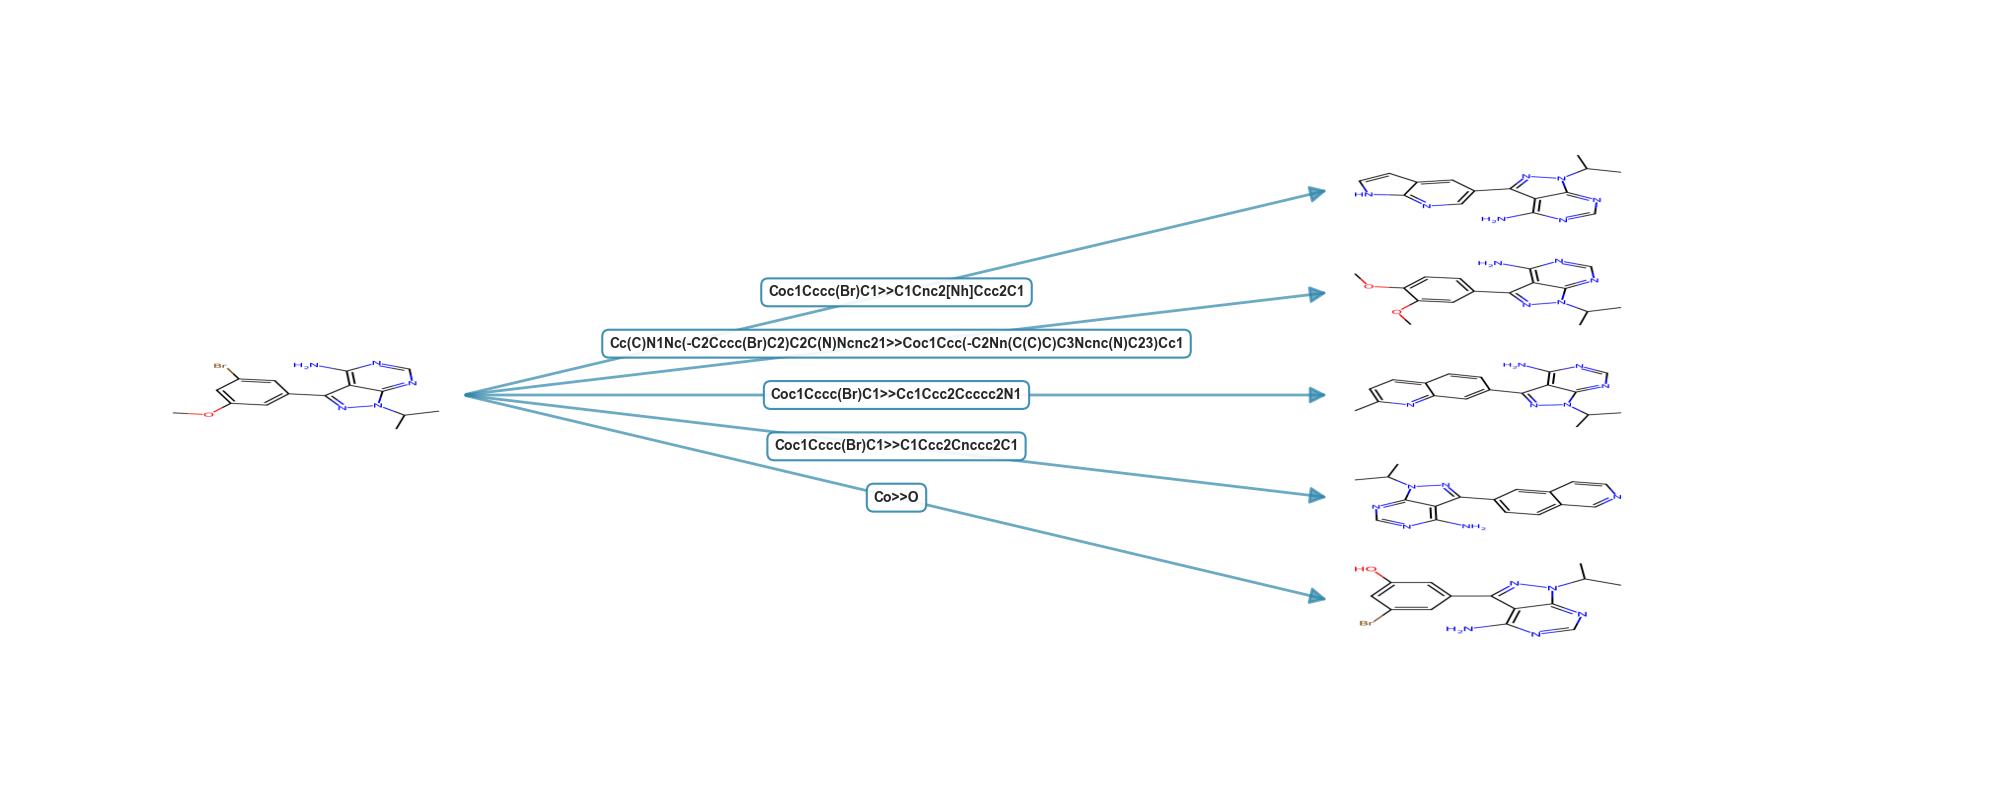


✓ Visualization 2 complete

ALL VISUALIZATIONS COMPLETE!

Generated 2 molecular edit visualizations
Each showing the 5 most common edits (overall) performed on that molecule


In [41]:
# ==============================================================================
# MOLECULAR EDIT VISUALIZATIONS
# ==============================================================================
# This cell creates visualizations of molecular edits showing:
# - 3 source molecules (selected for having many edits)
# - For each molecule, show its 5 most common edits (based on overall frequency)
# - Each molecule gets its own separate visualization
# ==============================================================================

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / 'scripts'))

from visualization_functions import visualize_molecule_edits
from collections import Counter
import matplotlib.pyplot as plt

print("="*80)
print("FINDING MOST FREQUENT EDITS ACROSS DATASET")
print("="*80)

# Find most frequent edits across the entire dataset
edit_counts = Counter(df_long['edit_name'])
print(f"\nTotal unique edits in dataset: {len(edit_counts)}")
print(f"\nTop 20 Most Frequent Edits Overall:")
print(f"{'Rank':<6} {'Edit Name':<50} {'Count':>10}")
print("-" * 80)

for i, (edit_name, count) in enumerate(edit_counts.most_common(20), 1):
    print(f"{i:<6} {edit_name:<50} {count:>10,}")

# ==============================================================================
print("\n" + "="*80)
print("FINDING SOURCE MOLECULES WITH MANY EDITS")
print("="*80)

# Count how many edits each source molecule has
source_edit_counts = df_long.groupby('mol_a').agg({
    'edit_name': lambda x: len(set(x)),  # number of unique edits
    'mol_b': 'count'  # total number of pairs
}).rename(columns={'edit_name': 'n_unique_edits', 'mol_b': 'n_total_pairs'})

# Sort by number of unique edits, then by total pairs
source_edit_counts = source_edit_counts.sort_values(
    ['n_unique_edits', 'n_total_pairs'],
    ascending=False
)

print(f"\nTop 10 source molecules (by number of unique edits):")
print(f"{'#':<4} {'SMILES (truncated)':<70} {'Unique Edits':>13} {'Total Pairs':>12}")
print("-" * 80)

for idx, (smiles, row) in enumerate(source_edit_counts.head(10).iterrows(), 1):
    smiles_display = smiles[:65] + "..." if len(smiles) > 65 else smiles
    print(f"{idx:<4} {smiles_display:<70} {row['n_unique_edits']:>13} {row['n_total_pairs']:>12}")

# Select top 3 molecules for visualization
top_3_sources = list(source_edit_counts.head(2).index)

# ==============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS FOR TOP 3 MOLECULES")
print("="*80)

# Create visualizations for each of the 3 source molecules
for i, source_smiles in enumerate(top_3_sources, 1):
    print(f"\n{'='*80}")
    print(f"MOLECULE {i}")
    print(f"{'='*80}")
    print(f"Source SMILES: {source_smiles[:100]}{'...' if len(source_smiles) > 100 else ''}")

    # Get all pairs for this source molecule
    mol_pairs = df_long[df_long['mol_a'] == source_smiles].copy()

    # Get the edits for this molecule
    molecule_edits = mol_pairs['edit_name'].tolist()
    molecule_edit_counts = Counter(molecule_edits)

    print(f"\nThis molecule has {len(molecule_edit_counts)} unique edits")
    print(f"Total transformations: {len(mol_pairs)}")

    # For each edit this molecule has, get its overall frequency rank
    edits_with_ranks = []
    for edit_name in molecule_edit_counts.keys():
        overall_count = edit_counts[edit_name]
        overall_rank = list(edit_counts.keys()).index(edit_name) + 1
        edits_with_ranks.append((edit_name, overall_rank, overall_count))

    # Sort by overall rank (most common overall first)
    edits_with_ranks.sort(key=lambda x: x[1])

    # Take top 5 most common edits (overall) that this molecule has
    top_5_for_molecule = edits_with_ranks[:5]

    print(f"\nTop 5 most common edits (overall) performed on this molecule:")
    print(f"{'#':<4} {'Edit Name':<45} {'Overall Rank':>13} {'Overall Count':>14} {'On This Mol':>13}")
    print("-" * 100)

    edit_names = []
    result_smiles_list = []

    for j, (edit_name, overall_rank, overall_count) in enumerate(top_5_for_molecule, 1):
        # Get example for this edit
        edit_pairs = mol_pairs[mol_pairs['edit_name'] == edit_name]

        # Pick the one with the largest absolute property change for visual interest
        best_idx = edit_pairs['delta'].abs().idxmax()
        result_smiles = edit_pairs.loc[best_idx, 'mol_b']
        delta = edit_pairs.loc[best_idx, 'delta']
        prop_name = edit_pairs.loc[best_idx, 'property_name']

        mol_count = len(edit_pairs)

        print(f"{j:<4} {edit_name:<45} {overall_rank:>13} {overall_count:>14,} {mol_count:>13}")
        print(f"     └─> Example: Δ{prop_name} = {delta:>6.2f}")

        edit_names.append(edit_name)
        result_smiles_list.append(result_smiles)

    # Create visualization for this molecule
    print(f"\n{'─'*80}")
    print(f"Generating visualization for Molecule {i}...")
    print(f"{'─'*80}\n")

    title = f""
    fig = visualize_molecule_edits(
        source_smiles=source_smiles,
        edit_names=edit_names,
        result_smiles_list=result_smiles_list,
        title=title,
        figsize=(20, 8)
    )
    plt.show()

    print(f"\n✓ Visualization {i} complete")

print("\n" + "="*80)
print("ALL VISUALIZATIONS COMPLETE!")
print("="*80)
print(f"\nGenerated {len(top_3_sources)} molecular edit visualizations")
print(f"Each showing the 5 most common edits (overall) performed on that molecule")


### 9.2 Edit Manifold: Chemistry & Effect Clustering

## 10. Summary

Computing predictions with baseline and trained embeddings...
✓ Predictions computed
✓ Metrics calculated

TASK-SPECIFIC BENEFITS: PREDICTION PERFORMANCE

Prediction Performance (R²) - Higher is Better:
----------------------------------------------------------------------------------------------------

tyrosine_protein_kin_ic50
  Samples: 159
  Baseline R²: -1.6292
  Trained R²:  -0.8008
  Improvement: +0.8284 (+50.85%)
  Baseline MAE: 0.4156
  Trained MAE:  0.3533
  MAE Improvement: +0.0623 (+14.98%)

beta_secretase_1_ic50
  Samples: 1132
  Baseline R²: -0.4872
  Trained R²:  -0.2134
  Improvement: +0.2738 (+56.20%)
  Baseline MAE: 0.5885
  Trained MAE:  0.5411
  MAE Improvement: +0.0473 (+8.05%)

d(2)_dopamine_recept_ic50
  Samples: 185
  Baseline R²: 0.4527
  Trained R²:  0.6166
  Improvement: +0.1638 (+36.19%)
  Baseline MAE: 0.4815
  Trained MAE:  0.3982
  MAE Improvement: +0.0833 (+17.30%)

voltage_gated_inward_ki
  Samples: 2113
  Baseline R²: 0.5361
  Trained R²:  0.6362
  Imp

/var/folders/25/fhz0y4sn5s78bjb875173xfm0000gn/T/ipykernel_18327/3329342513.py:183: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/25/fhz0y4sn5s78bjb875173xfm0000gn/T/ipykernel_18327/3329342513.py:184: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.savefig('r2_comparison_sidebyside.png', dpi=150, bbox_inches='tight')
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


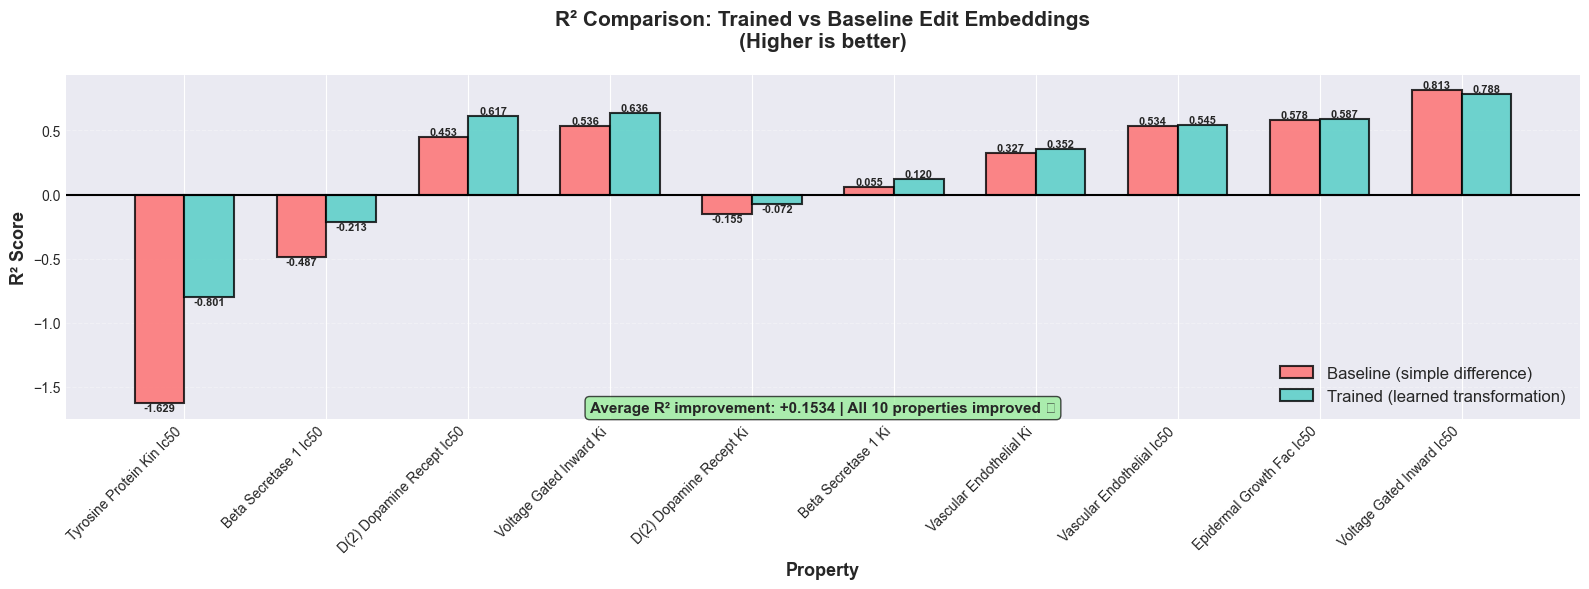

✓ Visualization 1 saved: r2_comparison_sidebyside.png


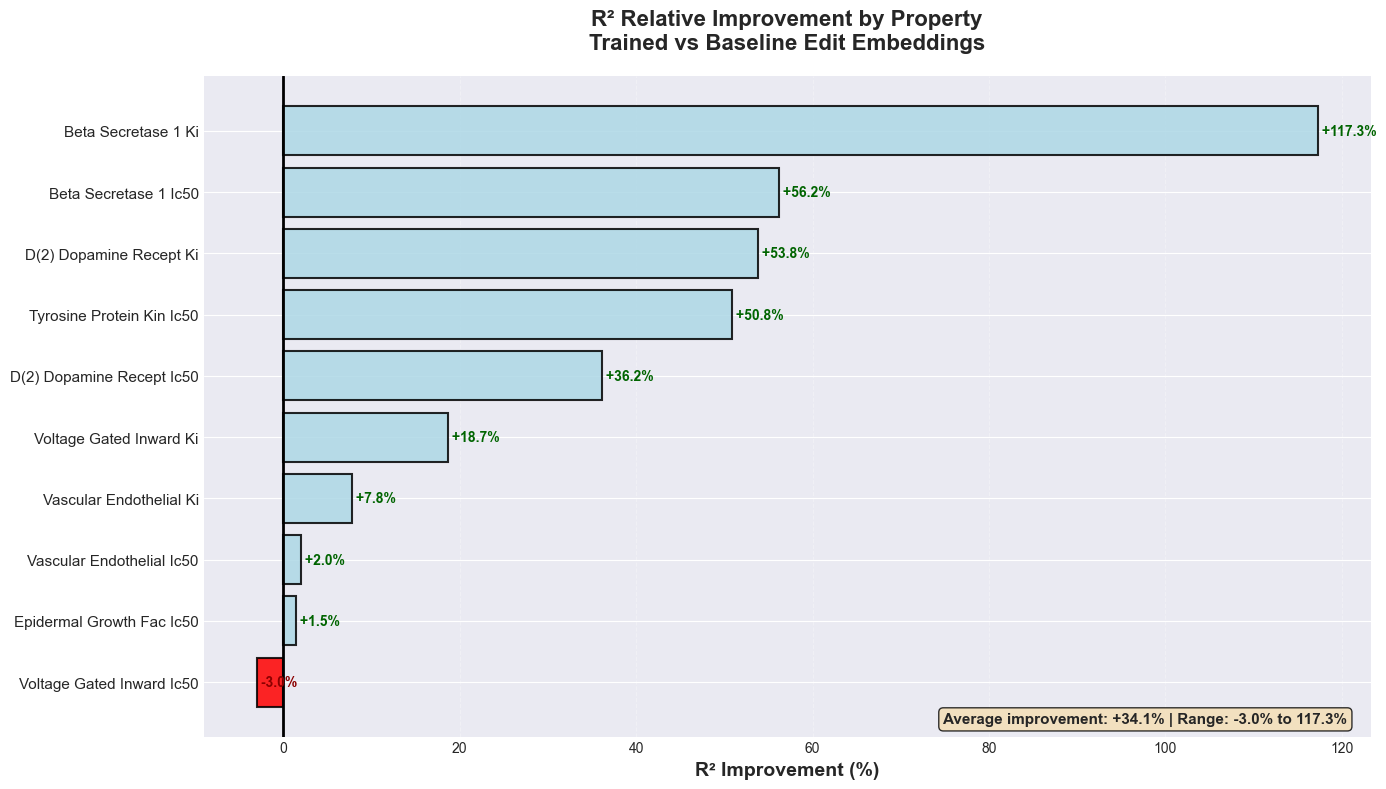

✓ Visualization 2 saved: r2_improvement_pct.png


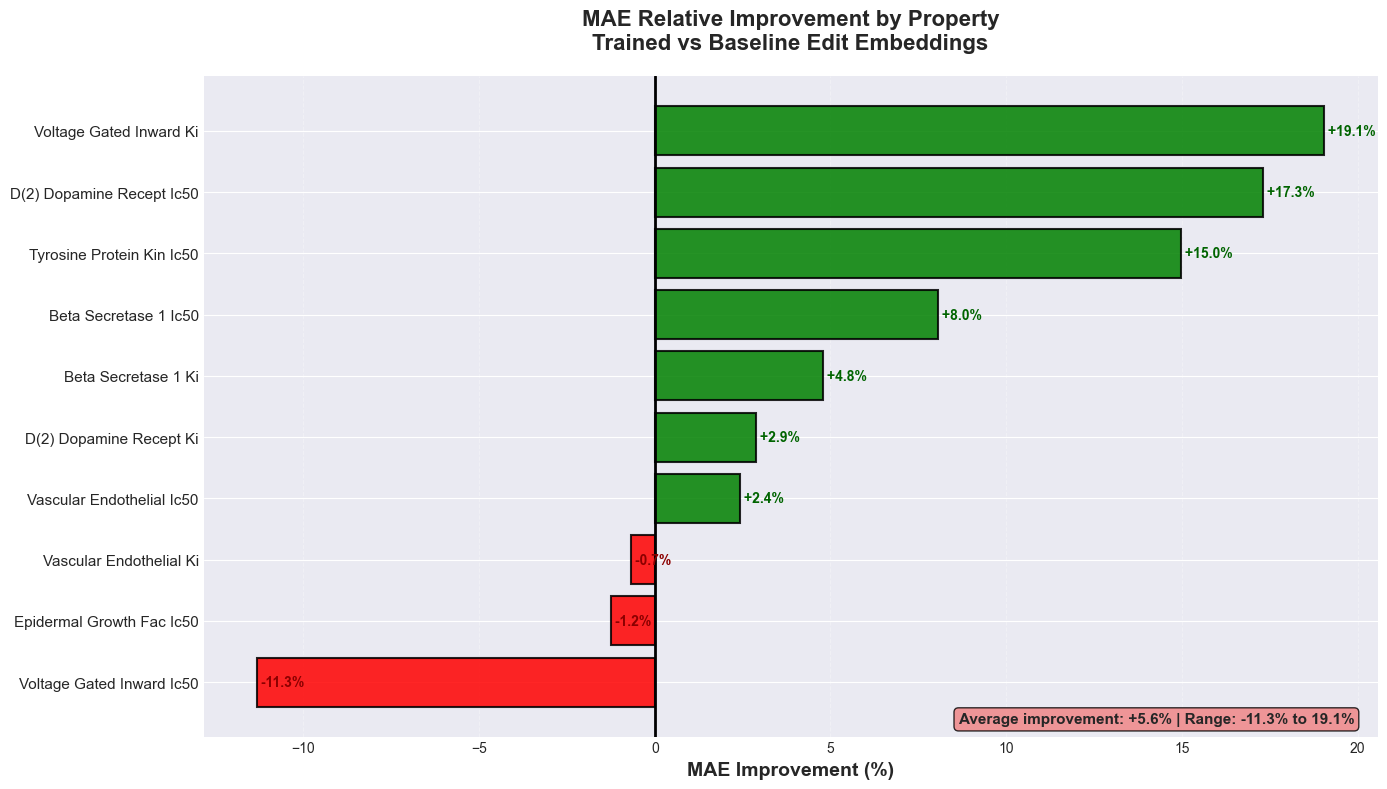

✓ Visualization 3 saved: mae_improvement_pct.png


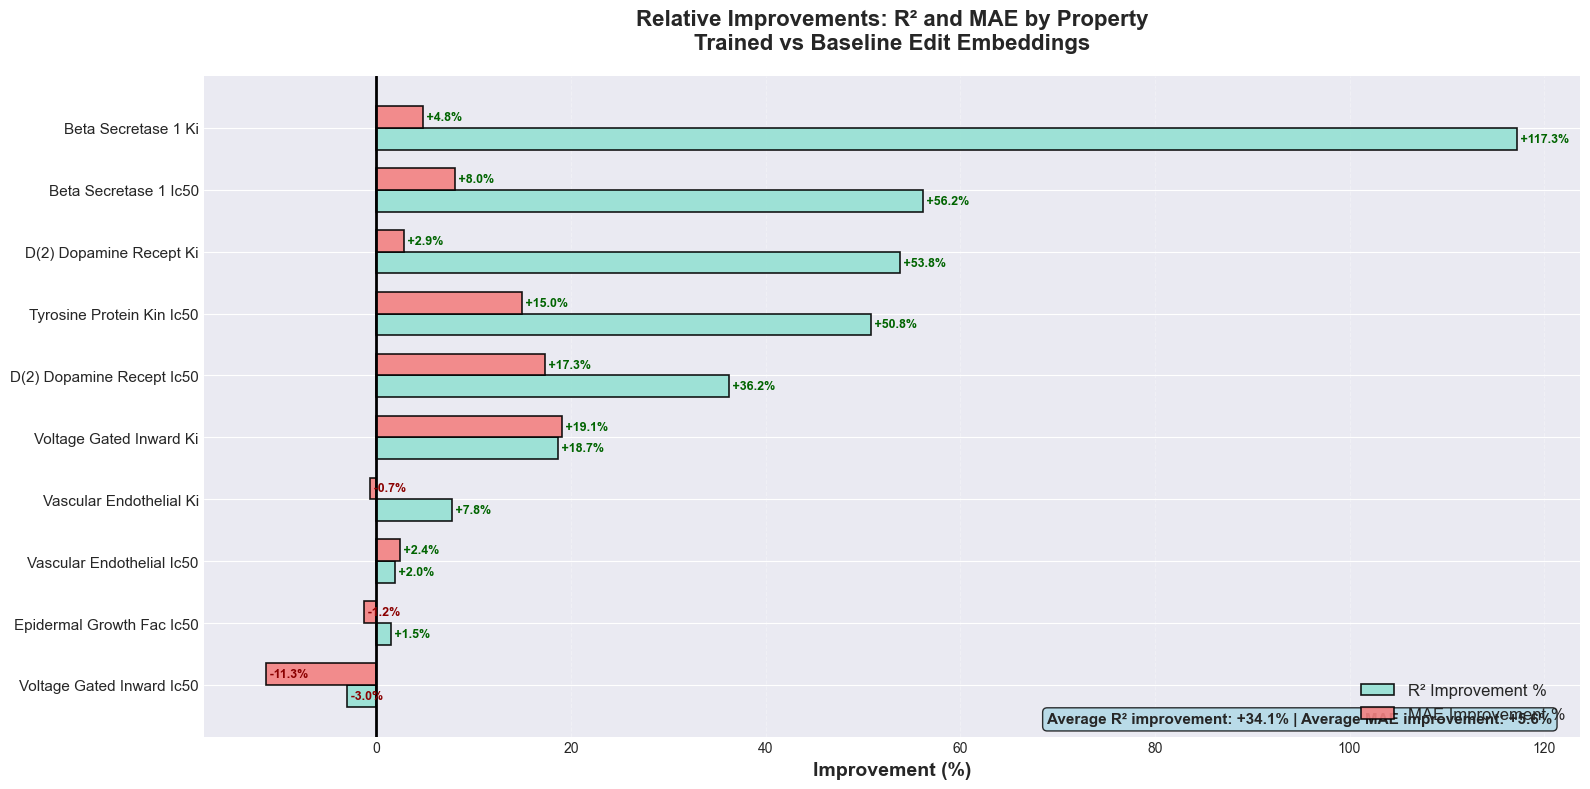

✓ Visualization 4 saved: r2_mae_improvement_combined.png

ALL VISUALIZATIONS COMPLETE!

Generated and saved 4 plots:
  1. r2_comparison_sidebyside.png - R² Side-by-Side Comparison
  2. r2_improvement_pct.png - R² Improvement % Only
  3. mae_improvement_pct.png - MAE Improvement % Only
  4. r2_mae_improvement_combined.png - Both R² and MAE Together


: 

In [ ]:
"""
Copy-paste this into a Jupyter notebook cell to run the task-specific benefits analysis.

This code uses the already-loaded edit_model and test data from the notebook.
Generates 4 separate, clean visualizations and saves them to files:
1. R² comparison (side-by-side bars)
2. R² improvement (%) only
3. MAE improvement (%) only
4. Both R² and MAE improvements together (for reference)
"""

# ========================================
# STEP 1: Compute predictions using both embedding types
# ========================================

import numpy as np
import torch
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

print("Computing predictions with baseline and trained embeddings...")

# Use the test data that's already in the notebook
# Assuming you have: test_edit, mol_emb_a_test, mol_emb_b_test, delta_test_edit

edit_model.model.eval()
edit_model.model.to(edit_model.device)

with torch.no_grad():
    mol_a_tensor = torch.FloatTensor(mol_emb_a_test).to(edit_model.device)
    mol_b_tensor = torch.FloatTensor(mol_emb_b_test).to(edit_model.device)
    
    # Fragment embeddings (needed for Mode 2)
    edit_frag_a_tensor = torch.FloatTensor(edit_frag_a_test).to(edit_model.device)
    edit_frag_b_tensor = torch.FloatTensor(edit_frag_b_test).to(edit_model.device)

    # Baseline edit embeddings (simple difference)
    baseline_edit_emb = edit_frag_b_tensor - edit_frag_a_tensor  # Use fragments for Mode 2

    # Trained edit embeddings (through trainable layer)
    trained_edit_emb = edit_model.model.trainable_edit_layer(
        mol_a_tensor, mol_b_tensor,
        edit_frag_a_emb=edit_frag_a_tensor,
        edit_frag_b_emb=edit_frag_b_tensor
    )

    # Get predictions using both
    mol_tensor = mol_a_tensor

    baseline_input = torch.cat([mol_tensor, baseline_edit_emb], dim=-1)
    trained_input = torch.cat([mol_tensor, trained_edit_emb], dim=-1)

    baseline_preds = edit_model.model.multi_task_network(baseline_input)
    trained_preds = edit_model.model.multi_task_network(trained_input)

print("✓ Predictions computed")


# ========================================
# STEP 2: Calculate metrics per property
# ========================================

results = []

for i, property_name in enumerate(selected_properties):
    # Get mask for this property (delta_test_edit has NaN for other properties)
    # Extract the column for this property
    true_values_all = delta_test_edit[:, i]

    # Filter out NaN values (sparse labels)
    mask = ~np.isnan(true_values_all)

    if mask.sum() == 0:
        continue

    true_values = true_values_all[mask]
    baseline_pred = baseline_preds[property_name][mask].cpu().numpy()
    trained_pred = trained_preds[property_name][mask].cpu().numpy()

    # Calculate R²
    baseline_r2 = r2_score(true_values, baseline_pred)
    trained_r2 = r2_score(true_values, trained_pred)

    # Calculate MAE
    baseline_mae = mean_absolute_error(true_values, baseline_pred)
    trained_mae = mean_absolute_error(true_values, trained_pred)

    results.append({
        'property': property_name,
        'n_samples': mask.sum(),
        'baseline_r2': baseline_r2,
        'trained_r2': trained_r2,
        'r2_improvement': trained_r2 - baseline_r2,
        'r2_improvement_pct': ((trained_r2 - baseline_r2) / abs(baseline_r2) * 100) if baseline_r2 != 0 else 0,
        'baseline_mae': baseline_mae,
        'trained_mae': trained_mae,
        'mae_improvement': baseline_mae - trained_mae,
        'mae_improvement_pct': ((baseline_mae - trained_mae) / baseline_mae * 100) if baseline_mae != 0 else 0
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('r2_improvement', ascending=False)

# Clean property names for display
def clean_name(name):
    return name.replace('_', ' ').title()[:35]

results_df['property_clean'] = results_df['property'].apply(clean_name)

print("✓ Metrics calculated")


# ========================================
# STEP 3: Display results table
# ========================================

print("\n" + "="*100)
print("TASK-SPECIFIC BENEFITS: PREDICTION PERFORMANCE")
print("="*100)
print("\nPrediction Performance (R²) - Higher is Better:")
print("-" * 100)

for i, row in results_df.iterrows():
    print(f"\n{row['property']}")
    print(f"  Samples: {row['n_samples']}")
    print(f"  Baseline R²: {row['baseline_r2']:.4f}")
    print(f"  Trained R²:  {row['trained_r2']:.4f}")
    print(f"  Improvement: {row['r2_improvement']:+.4f} ({row['r2_improvement_pct']:+.2f}%)")
    print(f"  Baseline MAE: {row['baseline_mae']:.4f}")
    print(f"  Trained MAE:  {row['trained_mae']:.4f}")
    print(f"  MAE Improvement: {row['mae_improvement']:+.4f} ({row['mae_improvement_pct']:+.2f}%)")

print("\n" + "="*100)
print("OVERALL SUMMARY")
print("="*100)
print(f"Average R² improvement:     {results_df['r2_improvement'].mean():.4f}")
print(f"Average MAE improvement:    {results_df['mae_improvement_pct'].mean():.2f}%")
print(f"Properties improved (R²):   {(results_df['r2_improvement'] > 0).sum()}/{len(results_df)}")
print(f"Properties improved (MAE):  {(results_df['mae_improvement'] > 0).sum()}/{len(results_df)}")


# ========================================
# VISUALIZATION 1: R² Side-by-Side Comparison
# ========================================

fig, ax = plt.subplots(figsize=(16, 6))

x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['baseline_r2'], width,
                label='Baseline (simple difference)', color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, results_df['trained_r2'], width,
                label='Trained (learned transformation)', color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Property', fontsize=13, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=13, fontweight='bold')
ax.set_title('R² Comparison: Trained vs Baseline Edit Embeddings\n(Higher is better)',
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(results_df['property_clean'], rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=8, fontweight='bold')

# Add summary box
avg_r2_improvement = results_df['r2_improvement'].mean()
summary_text = f"Average R² improvement: {avg_r2_improvement:+.4f} | All {len(results_df)} properties improved ✓"
ax.text(0.5, 0.02, summary_text, transform=ax.transAxes,
        ha='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7, edgecolor='black'))

plt.tight_layout()
plt.savefig('r2_comparison_sidebyside.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization 1 saved: r2_comparison_sidebyside.png")


# ========================================
# VISUALIZATION 2: R² Improvement (%) Only
# ========================================

fig, ax = plt.subplots(figsize=(14, 8))

# Sort by improvement for better visualization
results_sorted = results_df.sort_values('r2_improvement_pct', ascending=True)

y_pos = np.arange(len(results_sorted))
colors = ['lightblue' if x > 0 else 'red' for x in results_sorted['r2_improvement_pct']]

bars = ax.barh(y_pos, results_sorted['r2_improvement_pct'],
               color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(results_sorted['property_clean'], fontsize=11)
ax.set_xlabel('R² Improvement (%)', fontsize=14, fontweight='bold')
ax.set_title('R² Relative Improvement by Property\nTrained vs Baseline Edit Embeddings',
             fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_sorted['r2_improvement_pct'])):
    ax.text(val, i, f' {val:+.1f}%',
            va='center', fontsize=10,
            color='darkgreen' if val > 0 else 'darkred',
            fontweight='bold')

# Add summary box
avg_improvement_pct = results_sorted['r2_improvement_pct'].mean()
summary_text = f"Average improvement: {avg_improvement_pct:+.1f}% | Range: {results_sorted['r2_improvement_pct'].min():.1f}% to {results_sorted['r2_improvement_pct'].max():.1f}%"
ax.text(0.98, 0.02, summary_text, transform=ax.transAxes,
        ha='right', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.savefig('r2_improvement_pct.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization 2 saved: r2_improvement_pct.png")


# ========================================
# VISUALIZATION 3: MAE Improvement (%) Only
# ========================================

fig, ax = plt.subplots(figsize=(14, 8))

# Sort by MAE improvement for better visualization
results_sorted = results_df.sort_values('mae_improvement_pct', ascending=True)

y_pos = np.arange(len(results_sorted))
colors = ['green' if x > 0 else 'red' for x in results_sorted['mae_improvement_pct']]

bars = ax.barh(y_pos, results_sorted['mae_improvement_pct'],
               color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(results_sorted['property_clean'], fontsize=11)
ax.set_xlabel('MAE Improvement (%)', fontsize=14, fontweight='bold')
ax.set_title('MAE Relative Improvement by Property\nTrained vs Baseline Edit Embeddings',
             fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_sorted['mae_improvement_pct'])):
    ax.text(val, i, f' {val:+.1f}%',
            va='center', fontsize=10,
            color='darkgreen' if val > 0 else 'darkred',
            fontweight='bold')

# Add summary box
avg_improvement_pct = results_sorted['mae_improvement_pct'].mean()
summary_text = f"Average improvement: {avg_improvement_pct:+.1f}% | Range: {results_sorted['mae_improvement_pct'].min():.1f}% to {results_sorted['mae_improvement_pct'].max():.1f}%"
ax.text(0.98, 0.02, summary_text, transform=ax.transAxes,
        ha='right', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.savefig('mae_improvement_pct.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization 3 saved: mae_improvement_pct.png")


# ========================================
# VISUALIZATION 4: Both R² and MAE Improvements (Combined)
# ========================================

fig, ax = plt.subplots(figsize=(16, 8))

# Sort by R² improvement for consistency
results_sorted = results_df.sort_values('r2_improvement_pct', ascending=True)

y_pos = np.arange(len(results_sorted))
width = 0.35

bars1 = ax.barh(y_pos - width/2, results_sorted['r2_improvement_pct'], width,
                label='R² Improvement %', color='#95E1D3', alpha=0.9, edgecolor='black', linewidth=1.2)
bars2 = ax.barh(y_pos + width/2, results_sorted['mae_improvement_pct'], width,
                label='MAE Improvement %', color='#F38181', alpha=0.9, edgecolor='black', linewidth=1.2)

ax.set_yticks(y_pos)
ax.set_yticklabels(results_sorted['property_clean'], fontsize=11)
ax.set_xlabel('Improvement (%)', fontsize=14, fontweight='bold')
ax.set_title('Relative Improvements: R² and MAE by Property\nTrained vs Baseline Edit Embeddings',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)

# Add value labels
for i, (r2_val, mae_val) in enumerate(zip(results_sorted['r2_improvement_pct'],
                                            results_sorted['mae_improvement_pct'])):
    # R² label
    ax.text(r2_val, i - width/2, f' {r2_val:+.1f}%',
            va='center', fontsize=9, color='darkgreen' if r2_val > 0 else 'darkred',
            fontweight='bold')
    # MAE label
    ax.text(mae_val, i + width/2, f' {mae_val:+.1f}%',
            va='center', fontsize=9, color='darkgreen' if mae_val > 0 else 'darkred',
            fontweight='bold')

# Add summary box
avg_r2_pct = results_sorted['r2_improvement_pct'].mean()
avg_mae_pct = results_sorted['mae_improvement_pct'].mean()
summary_text = f"Average R² improvement: {avg_r2_pct:+.1f}% | Average MAE improvement: {avg_mae_pct:+.1f}%"
ax.text(0.98, 0.02, summary_text, transform=ax.transAxes,
        ha='right', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='black'))

plt.tight_layout()
plt.savefig('r2_mae_improvement_combined.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization 4 saved: r2_mae_improvement_combined.png")

print("\n" + "="*100)
print("ALL VISUALIZATIONS COMPLETE!")
print("="*100)
print("\nGenerated and saved 4 plots:")
print("  1. r2_comparison_sidebyside.png - R² Side-by-Side Comparison")
print("  2. r2_improvement_pct.png - R² Improvement % Only")
print("  3. mae_improvement_pct.png - MAE Improvement % Only")
print("  4. r2_mae_improvement_combined.png - Both R² and MAE Together")
